# The work below is not meant as a final project. It is a developing project.

## Project 4 – Work In Progress

* Student name: Greg Osborne
* Student pace: self paced / part time
* Scheduled project review date/time: 3/6/23
* Instructor name: Morgan Jones
* Blog post URL: https://medium.com/@gregosborne

## Business Understanding
### Stakeholder: 
Google
### Problem: 
Some people view Google more negatively than their chief competitor, Apple. Google needs a tool to help measure the publics' sentiment toward both Apple and Google to strategize for a more positive public sentiment. This tool will offer Google insight for how they can work towards a more positive public sentiment. 

### Using NLP to build a tool

Google's Public Relations and product development departments could benefit from a snapshot of the publics' perception of both Google and their competition, Apple. The [insert what the model does here]

1. [itemized list]

Greg Osborne accepted the challenge to build such a tool.

## Python Libraries

In [1]:
#DataFrames and computation
import pandas as pd
import numpy as np

#The Train/Test Split
from sklearn.model_selection import train_test_split

#For Categorical Variables
#from sklearn.preprocessing import OneHotEncoder

#For Min/Max Scaling
#from sklearn.preprocessing import MinMaxScaler

#Logistic Regression Model
#from sklearn.linear_model import LogisticRegression

# Scores
#from sklearn.metrics import precision_score, recall_score, accuracy_score
#from sklearn.metrics import f1_score

# For Frequency Distributions
from nltk import FreqDist
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

#Import the Tokenize library
from nltk.tokenize import RegexpTokenizer

# For Wordclouds
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

# For stopwords
import nltk
from nltk.corpus import stopwords

# The Confusion Matrix
#import matplotlib.pyplot as plt
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix

#Decision Tree Analysis
#from sklearn.tree import DecisionTreeClassifier
#from sklearn import tree
#from sklearn.metrics import roc_curve, auc

# Import StandardScaler
#from sklearn.preprocessing import StandardScaler

# Import KNeighborsClassifier
#from sklearn.neighbors import KNeighborsClassifier

# Import Bagging Trees
#from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

# For XG Boost
#from sklearn.model_selection import GridSearchCV
#from xgboost import XGBClassifier

#Setting DataFrame Display settings
#pd.options.display.max_colwidth = 1000
pd.set_option("display.max_rows", 600)

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
pd.options.display.float_format = '{:,.3f}'.format

## Custom Functions

### *tally*: Creates a dictionary that counts the elements of a list

In [2]:
#Creates a dictionary of specified keys with a count as the values, and then
#sorts the list from greatest to least.
def tally(lst):
    tally_dict = {}
    for item in lst:
        if item not in tally_dict:
            tally_dict[item] = 1
        else:
            tally_dict[item] += 1
    #Sorting the dictionaries
    count = sorted(tally_dict.items(), key=lambda x: x[1], reverse=True)
    return count

### *retweet_trim_one*: Creates a DataFrame of nothing but the retweets found in the specified DataFrame
The next four functions go together. They allow the user to remove words from the beginning of each retweet, then test to see if the resulting trimmed tweet matches an original tweet in the dataset. The point of this is to remove data that is identical in all but the first two words, with the first being "rt" for retweet.

In [3]:
#Creating a df of nothing but the retweets
def retweet_trim_one(dfone):
    for i in dfone.index:
        twt = dfone.loc[i, 'Tokens']
        #Twitter parlance: rt = retweet
        #Dropping all tweets that don't start in rt
        if 'rt' != twt[0]:
            dfone.drop(index=i, inplace=True)
    return dfone

### *retweet_trim_two*: Trimming the terms rt and mention from the beginning of the tweet, counting the first and second words of the remaining tweets, and determining which tweets to drop. 

In [4]:
#Creating a new column that will have the same tokens, just without rt or
#mention at the beginning.

def retweet_trim_two(dftwo, drop_first_words=['skip'], drop_num=1):
    #Creating a column to put the trimmed retweet
    dftwo['trimmed_rt'] = 'Blank'
    dftwo['Match'] = False

    #I want to test the data to see if there's anything that stands out as
    #repetitive in the first or second words of the newly trimmed tweets.
    #Creating a list of the first and second words of each trimmed tweet.
    firstword_lst = []
    secondword_lst = []

    #Starting a list to drop any retweets.
    retweets_to_drop = []

    for i in dftwo.index:
        #making the trimmed variable, the tokens of the next tweet to edit
        trimmed = dftwo.at[i, 'Tokens']
        #Removing the set number of dropped tokens.
        #Default is just the first token, "rt."
        trimmed = trimmed[drop_num:]
        if len(trimmed) == 0:
            if drop_num == 1:
                retweets_to_drop.append(i)
            continue
        #Several retweets include 'mention' after the rt, so I'll trim that.
        #This while loop quits dropping words with the first token that isn't
        #in the drop list specified by parameter.
        if drop_first_words != ['skip']:
            while trimmed[0] in drop_first_words:
                trimmed = trimmed[1:]
                #Some tweets contained only "rt" and "mention," and are now
                #empty."
                #Adding any empty token lists to the retweets_to_drop list.
                if len(trimmed) == 0:
                    if drop_num == 1:
                        retweets_to_drop.append(i)
                    break
        if len(trimmed) == 0:
            continue

        #Adding first and second words of the trimmed tweet to the lists.
        firstword_lst.append(trimmed[0])
        secondword_lst.append(trimmed[1])

        #Replacing the trimmed tokens to a new column, "trimmed_rt".
        dftwo.at[i, 'trimmed_rt'] = trimmed

    #I want to test the data to see if there's anything that stands out as
    #repetitive in the first word of the newly trimmed tweets.
    #Creating a dictionary to count the first word in each trimmed tweet.

    firstword_count = tally(firstword_lst)
    secondword_count = tally(secondword_lst)

    return dftwo, firstword_count, secondword_count, retweets_to_drop

### *retweet_trim_three*: Checking to see if any of the trimmed retweets have exact matches in the original dataset and then identifies the tweets that need deleting if that's the case.

In [5]:
#Checking to see if any of theses newly trimmed retweets are exact matches of
#Original tweets in the dataset.


def retweet_trim_three(dfthree, dforg, retweets_to_drop):
    original_tweets = []

    for i in dforg.index:
        original_tweets.append(dforg.at[i, 'Tokens'])

    for i in dfthree.index:
        retweet = dfthree.at[i, 'trimmed_rt']
        if retweet in original_tweets:
            dfthree.at[i, 'Match'] = True
            retweets_to_drop.append(i)

    return dfthree, retweets_to_drop

### *retweet_trim_all*: Combines the previous three functions and then deletes the retweets with matching original values in the dataset. Parameters allow different options.

In [6]:
#Creating a single function that runs all of the previous functions but allows
#a lister parameter to choose what words are filtered out of the first words.
def retweet_trim_all(retweets, word_list=['skip'], delete=True, drop=1):
    retweets = retweet_trim_one(retweets)
    retweets, fw, sw, rtd = retweet_trim_two(retweets, word_list, drop)
    retweets, rtd = retweet_trim_three(retweets, df, rtd)
    #Dropping the tweets.
    if delete == False:
        print(retweets['Match'].value_counts())
        return retweets.loc[retweets['Match'] == True]
    df.drop(index=rtd, inplace=True)
#    df.reset_index(drop=True, inplace=True)
    return retweets['Match'].value_counts()

### *visualize_top_10*: Returns a visualization of the distribution of the top ten words in the specified data.

In [7]:
def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)

### *setup_twelve_subplots*: Sets up twelve subplots. This is used with other functions.

In [8]:
def setup_twelve_subplots():
    fig = plt.figure(figsize=(9, 12))
    fig.set_tight_layout(True)
    gs = fig.add_gridspec(4, 3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    ax4 = fig.add_subplot(gs[1, 0])
    ax5 = fig.add_subplot(gs[1, 1])
    ax6 = fig.add_subplot(gs[1, 2])
    ax7 = fig.add_subplot(gs[2, 0])
    ax8 = fig.add_subplot(gs[2, 1])
    ax9 = fig.add_subplot(gs[2, 2])
    ax10 = fig.add_subplot(gs[3, 0])
    ax11 = fig.add_subplot(gs[3, 1])
    ax12 = fig.add_subplot(gs[3, 2])
    return fig, [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]

### *plots*: Sets up twelve word frequency distributions for all target categories.

In [9]:
def plots(dataf, targ, column, axes, title="Word Frequency for"):
    ax_num = 0
    for index, category in zip(df_target.index, df_target.values):
        # Calculate frequency distribution for this subset
        all_words = dataf[targ == index][column].explode()
        freq_dist = FreqDist(all_words)
        top_10 = list(zip(*freq_dist.most_common(10)))
        tokens = top_10[0]
        counts = top_10[1]

        # Set up plot
        ax = axes[ax_num]
        ax.bar(tokens, counts)

        # Customize plot appearance
        ax.set_title(f"{title} \n {str(category)[2:-2]}")
        ax.set_ylabel("Count")
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.tick_params(axis="x", rotation=90)
        ax_num += 1

### *wc*: Plots a single word cloud for the specified data.

In [10]:
def wc(tokens, title=''):
    if isinstance(tokens, pd.Series):
        text = " ".join(i for i in tokens.explode())
    else:
        text = " ".join(i for i in tokens)
    wordcloud = WordCloud(background_color="white").generate(text)
    fig = plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    fig.set_tight_layout(True)

    if title != '':
        fig.suptitle(title, fontsize=48)
    plt.show()

### *word_cloud_grid*: Plots twelve word clouds for each specified target.

In [11]:
def word_cloud_grid(dataf, targ, column, title=''):
    tgt_lst = []
    wc_lst = []
    tgt_num = list(df_target.index)

    for num in tgt_num:
        tgt_lst.append(" ".join(
            i for i in dataf[column].loc[targ == num].explode()))
    for tgt in tgt_lst:
        wc_lst.append(WordCloud(background_color="white").generate(tgt))
    fig = plt.figure(figsize=(9, 9))
    fig.set_tight_layout(True)
    gs = fig.add_gridspec(4, 3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    ax4 = fig.add_subplot(gs[1, 0])
    ax5 = fig.add_subplot(gs[1, 1])
    ax6 = fig.add_subplot(gs[1, 2])
    ax7 = fig.add_subplot(gs[2, 0])
    ax8 = fig.add_subplot(gs[2, 1])
    ax9 = fig.add_subplot(gs[2, 2])
    ax10 = fig.add_subplot(gs[3, 0])
    ax11 = fig.add_subplot(gs[3, 1])
    ax12 = fig.add_subplot(gs[3, 2])

    i = 0
    for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]:
        ax.axis("off")
        ax.imshow(wc_lst[i], interpolation='bilinear')
        ref = tgt_num[i]
        ax.set_title(f"Word Cloud \n {df_target.at[ref,'Target Text']}")
        i += 1
    if title != '':
        fig.suptitle(title, fontsize=36)
    plt.show()

In [12]:
def word_assoc_cloud(pos_assoc, neg_assoc, word, title = '', subs = []):
    word_cap = word.capitalize()
    pos_lst = []
    neg_lst = []
    for i in range(len(pos_assoc)):
        pos_lst.append(pos_assoc[i][0])
        neg_lst.append(neg_assoc[i][0])
    pos_text = " ".join(i for i in pos_lst)
    neg_text = " ".join(i for i in neg_lst)
    wc_lst = []

    wc_lst.append(WordCloud(background_color="white").generate(pos_text))
    wc_lst.append(WordCloud(background_color="white").generate(neg_text))
    
    fig = plt.figure(figsize=(9, 4))
    fig.set_tight_layout(True)
    gs = fig.add_gridspec(1, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    
    if subs == []:
        subtitles = ['Associated With '     + word_cap,
                     'Not Associated With ' + word_cap]
    else:
        subtitles = subs
    i = 0
    for ax in [ax1, ax2]:
        ax.spines['bottom'].set_color('0.5')
        ax.spines['top'].set_color('0.5')
        ax.spines['right'].set_color('0.5')
        ax.spines['left'].set_color('0.5')
        ax.patch.set_facecolor('0.1')
        ax.tick_params(axis='x', which='both', bottom = False, 
                       labelbottom = False)
        ax.tick_params(axis='y', which='both', left = False, 
                       labelleft = False)
        ax.yaxis.label.set_color('0.9')
        ax.xaxis.label.set_color('0.9')
        ax.margins(0.5)
        ax.imshow(wc_lst[i], interpolation='bilinear')
        ax.set_title(subtitles[i], fontsize=18)
        i += 1
    if title != '':
        fig.suptitle(title, fontsize=24)
    plt.show()

### *remove_stopwords*: Returns a token list without the list of specified stopwords.

In [13]:
def remove_stopwords(token_list, stop_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    stopwords_removed = [
        token for token in token_list if token not in stop_list
    ]
    return stopwords_removed

## Loading the Data and Previewing It

In [14]:
df_raw = pd.read_csv("judge-1377884607_tweet_product_company.csv",
                     encoding='ANSI')
df_raw.head(7)

tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   
5  @teachntech00 New iPad Apps For #SpeechTherapy...   
6                                                NaN   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   
5                             NaN   
6                             NaN   

  is_there_an_emotion_directed_at_a_brand_or_product  
0                                   Negative emotion  
1                                   Positive emotion  
2                                   Positive emotion  
3                                   Negative emotion  
4                                   Positive emotion  
5                 No emotion toward brand or product  
6                 No emotion toward brand or product

In [15]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


### Value counts of categorized columns

In [16]:
df_raw['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [17]:
df_raw['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

Analysis and explanation of next steps.

## Data Cleaning

### Rename Columns

In [18]:
def rename_columns(dforg):
    name = {
        'tweet_text': 'Tweet',
        'emotion_in_tweet_is_directed_at': 'Product',
        'is_there_an_emotion_directed_at_a_brand_or_product': 'Emotion'
        }
    dfone = dforg.copy()
    dfone = dfone.rename(columns=name)
    return dfone.copy()
df = rename_columns(df_raw)
df.head()

Tweet             Product  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone   
1  @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2  @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3  @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google   

            Emotion  
0  Negative emotion  
1  Positive emotion  
2  Positive emotion  
3  Negative emotion  
4  Positive emotion

### Standardizing Case

In [19]:
df['Tweet'] = df['Tweet'].str.lower()
df.head()

Tweet             Product  \
0  .@wesley83 i have a 3g iphone. after 3 hrs twe...              iPhone   
1  @jessedee know about @fludapp ? awesome ipad/i...  iPad or iPhone App   
2  @swonderlin can not wait for #ipad 2 also. the...                iPad   
3  @sxsw i hope this year's festival isn't as cra...  iPad or iPhone App   
4  @sxtxstate great stuff on fri #sxsw: marissa m...              Google   

            Emotion  
0  Negative emotion  
1  Positive emotion  
2  Positive emotion  
3  Negative emotion  
4  Positive emotion

### Testing for bad data

In [20]:
#Testing for any Tweets that are not strings
bad_tweets = []
for i in range(len(df)):
    typ = type(df.loc[i, 'Tweet'])
    if typ != str:
        print('Index number {} is a {}, not a string'.format(i, typ))
        bad_tweets.append(i)

Index number 6 is a <class 'float'>, not a string


In [21]:
#Dropping bad data and reseting the index
df.drop(index=bad_tweets, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head(8)

Tweet             Product  \
0  .@wesley83 i have a 3g iphone. after 3 hrs twe...              iPhone   
1  @jessedee know about @fludapp ? awesome ipad/i...  iPad or iPhone App   
2  @swonderlin can not wait for #ipad 2 also. the...                iPad   
3  @sxsw i hope this year's festival isn't as cra...  iPad or iPhone App   
4  @sxtxstate great stuff on fri #sxsw: marissa m...              Google   
5  @teachntech00 new ipad apps for #speechtherapy...                 NaN   
6  #sxsw is just starting, #ctia is around the co...             Android   
7  beautifully smart and simple idea rt @madebyma...  iPad or iPhone App   

                              Emotion  
0                    Negative emotion  
1                    Positive emotion  
2                    Positive emotion  
3                    Negative emotion  
4                    Positive emotion  
5  No emotion toward brand or product  
6                    Positive emotion  
7                    Positive emotion

### Combining compound nouns
A compound noun is two or more words that make a noun that are not referring to the same thing separately. For instance, *Apple* can mean the brand, *Store* can mean any store, but the compound noun *Apple Store* refers to something neither word refers to alone.

When performing NLP, I'll get better results if I standardize the compound nouns using underscores for spaces. I'll do this before tokenization.

In [22]:
def string_replace(dfone, begin_replace, replace_dict, to_print = True):
    counts = pd.DataFrame(columns = ['Replaced'])
    for n in range(len(dfone)):
        tweet = dfone.loc[n,'Tweet']
        for fnd, replce in zip(begin_replace.keys(), begin_replace.values()):
            if fnd in tweet[0:len(fnd)]:
                tweet = replce + tweet[len(fnd):]
                replced = fnd + ' / ' + replce
                counts.at[len(counts),'Replaced'] = replced
                dfone.loc[n,'Tweet'] = ''+tweet
        for find, replace in zip(replace_dict.keys(), replace_dict.values()):
            if find in tweet:
                change = False
                first = tweet[0:len(find)]
                last = tweet[len(tweet) - len(find):]
                if (find in first):
                    change = True
                    tweet = replace + tweet[len(find):]
                    replaced = find + ' / ' + replace
                    counts.at[len(counts),'Replaced'] = replaced
                if (find in last):
                    change = True
                    tweet = tweet[:len(tweet)-len(find)] + replace
                    replaced = find + ' / ' + replace
                    counts.at[len(counts),'Replaced'] = replaced
                complete = 0
                while complete < len(tweet) - len(find):
                    for i in range(0, len(tweet) - len(find)):
                        if find in tweet[i:i+len(find)]:
                            change = True
                            first = tweet[:i]
                            last = tweet[i+len(find):]
                            tweet = first + replace + last
                            complete = 0
                            replaced = find + ' / ' + replace
                            counts.at[len(counts),'Replaced'] = replaced
                            break
                        else:
                            complete += 1
                if change == True:
                    dfone.loc[n,'Tweet'] = ''+tweet
    if to_print == True:
        if counts.empty:
            print('No replacements made.')
        else:
            print(counts.value_counts())
    return dfone.copy()

In [23]:
first_replace = {'mayer'                 : 'marissa_mayer',
                 'vinh'                  : 'khoi_vinh'}

replacements =  {'apple store'           : 'apple_store',
                 'applestore'            : 'apple_store',
                 'apple_stores'          : 'apple_store',
                 'app store'             : 'app_store',
                 'appstore'              : 'app_store',
                 'marissa mayer'         : 'marissa_mayer',
                 'marissa meyer'         : 'marissa_mayer',
                 'marissameyer'          : 'marissa_mayer',
                 'marissamayer'          : 'marissa_mayer',
                 'marisa meyer'          : 'marissa_mayer',
                 'marissa@mention'       : 'marissa_mayer',
                 'melissa mayer'         : 'marissa_mayer',
                 'merissa mayer'         : 'marissa_mayer',
                 'm mayer'               : 'marissa_mayer',
                 'm.mayer'               : 'marissa_mayer',
                 '-mayer'                : 'marissa_mayer',
                 '#mayer'                : '#marissa_mayer',
                 ' mayer'                : 'marissa_mayer',
                 'marissa_mayers'        : 'marissa_mayer',
                 "marissa_mayer's"       : 'marissa_mayer',
                 'mentionmarissa_mayer'  : 'mention marissa_mayer',
                 '#mayer'                : '#marissa_mayer',
                 "tim o'reilly"          : "tim_o_reilly",
                 'tim oreilly'           : "tim_o_reilly",
                 "tim_o'reilly's"        : "tim_o_reilly",
                 "tim_o'reillys"         : "tim_o_reilly",
                 "'re"                   : ' are',
                 'tim o areily'          : "tim_o_reilly",
                 'tim soo'               : 'tim_soo',
                 'tim ferris'            : 'tim_ferris',
                 'tim_ferriss'           : 'tim_ferris',
                 'tim wu'                : 'tim_wu',
                 'matt mullenweg'        : 'matt_mullenweg',
                 'matt_mullenwegs'       : 'matt_mullenweg',
                 "matt_mullenweg's"      : 'matt_mullenweg',
                 'jonathan dahl'         : 'jonathan_dahl',
                 'mark belinsky'         : 'mark_belinsky',
                 'maggie mae'            : 'maggie_mae',
                 'maggie may'            : 'maggie_mae',
                 "maggie_mae's"          : 'maggie_mae',
                 "maggie_maes"           : 'maggie_mae',
                 "mike tyson"            : 'mike_tyson',
                 "mike_tyson's"          : 'mike_tyson',
                 "mike_tysons"           : 'mike_tyson',
                 "tyson's"               : 'mike_tyson',
                 'matt damon'            : 'matt_damon',
                 'barry diller'          : 'barry_diller',
                 'nyt'                   : 'ny_times',
                 'new york times'        : 'ny_times',
                 'ny times'              : 'ny_times',
                 "can't"                 : 'can not',
                 "won't"                 : 'would not',
                 "n't"                   : ' not',
                 "'ve"                   : ' have',
                 "'ll"                   : ' will',
                 'steve jobs'            : 'steve_jobs',
                 'pop up'                : 'pop_up',
                 'popup'                 : 'pop_up',
                 'pop-up'                : 'pop_up',
                 'pop shop'              : 'pop_up shop',
                 'pop-uitp'              : 'pop_up',
                 'pop- up'               : 'pop_up',
                 'pop-u‰û_'              : 'pop_up',
                 'pop-store'             : 'pop_up store',
                 'pop store'             : 'pop_up store',
                 'wi-fi'                 : 'wifi',
                 'wi fi'                 : 'wifi',
                 '.com'                  : 'com',
                 'dennis crowley'        : 'dennis_crowley',
                 ' crowley'              : 'dennis_crowley',
                 'i-phone'               : 'iphone',
                 'i-pad'                 : 'ipad',
                 'ipads'                 : 'ipad',
                 'iphones'               : 'iphone',
                 'ipad 2'                : 'ipad2',
                 'ipad_2'                : 'ipad2',
                 'ipad2s'                : 'ipad2',
                 'ipad 1'                : 'ipad1',
                 'ipad1s'                : 'ipad1',
                 'iphone app'            : 'iphone_app',
                 'ipad app'              : 'ipad_app',
                 'andoid'                : 'android',
                 'droid app'             : 'droid_app',
                 'iphone_app_store'      : 'iphone app_store',
                 'ipad_app_store'        : 'ipad app_store',
                 'droid_app_store'       : 'droid app_store',
                 'iphone_apps'           : 'iphone_app',
                 'ipad_apps'             : 'ipad_app',
                 'iphone_application'    : 'iphone application',
                 'droid_apps'            : 'droid_app',
                 ' droid_app'            : ' android_app',
                 'ûªll'                  : ' will',
                 "‰ûªs"                  : "'s",
                 "‰ûªre"                 : ' are',
                 "ûªt"                   : ' not',
                 'khoi vinh'             : 'khoi_vinh',
                 'jonathan ive'          : 'jonathan_ive',
                 'winsåêsxsw'            : 'wins sxsw',
                 'matt carlson'          : 'matt_carlson',
                 'matthew davis'         : 'matthew_davis',
                 'william patry'         : 'william_patry',
                 'josh williams'         : 'josh_williams',
                 'david foster'          : 'david_foster',
                 'david carr'            : 'david_carr',
                 'û_please'              : 'please',
                 'adam beckley'          : 'adam_beckley',
                 'paul adams'            : 'paul_adams'}

df = string_replace(df, first_replace, replacements)

Replaced                                    
ipad 2 / ipad2                                  988
apple store / apple_store                       597
pop-up / pop_up                                 423
n't /  not                                      377
're /  are                                      269
iphone app / iphone_app                         251
popup / pop_up                                  222
marissa mayer / marissa_mayer                   178
ipad app / ipad_app                             157
pop up / pop_up                                 157
'll /  will                                     139
've /  have                                     117
.com / com                                       97
app store / app_store                            90
ipads / ipad                                     89
can't / can not                                  78
droid app / droid_app                            73
ipad2s / ipad2                                   47
ipad_apps / ipad_ap

### Tokenize
The process of tokenizing the data is to turn each tweet into a list, with each element being a single item in the list.

In [24]:
# Creating the tokenizer
basic_token_pattern = r"(?u)\b\w\w+\b"
words_and_hashtags_token_pattern = r"(?u)\#?\b\w\w+\b"
hashtags_token_pattern = r"(?u)\#\b\w\w+\b"

tokenizer = RegexpTokenizer(basic_token_pattern)
hashtag_tokenizer = RegexpTokenizer(hashtags_token_pattern)
words_and_hashtags_tokenizer = RegexpTokenizer(words_and_hashtags_token_pattern)

In [25]:
# Creating a new column for the tokenized tweet
def tokenize_columns(dfone):
    dfone['Tokens'] = None
    dfone['Hashtags'] = None

    # Creating the token lists
    for i in range(len(dfone)):
        dfone['Tokens'][i] = tokenizer.tokenize(dfone['Tweet'][i])
        dfone['Hashtags'][i] = hashtag_tokenizer.tokenize(dfone['Tweet'][i])
    return dfone.copy()

df = tokenize_columns(df)

In [26]:
# Previewing the top 100 words.
all_tokens = []
for num in df.index:
    new = df.loc[num, 'Tokens']
    for word in new:
        all_tokens.append(word)
cut_tweet_word_counts = tally(all_tokens)

print(len(cut_tweet_word_counts))
cut_tweet_word_counts[0:100]

9781


[('sxsw', 9628),
 ('mention', 7122),
 ('the', 4435),
 ('link', 4313),
 ('to', 3605),
 ('at', 3105),
 ('rt', 2967),
 ('google', 2659),
 ('for', 2548),
 ('in', 1978),
 ('is', 1736),
 ('apple', 1730),
 ('of', 1714),
 ('quot', 1696),
 ('and', 1638),
 ('ipad2', 1475),
 ('ipad', 1436),
 ('iphone', 1354),
 ('on', 1335),
 ('you', 1084),
 ('new', 1084),
 ('it', 1067),
 ('not', 1029),
 ('austin', 973),
 ('an', 873),
 ('with', 867),
 ('amp', 836),
 ('my', 829),
 ('store', 809),
 ('are', 802),
 ('pop_up', 798),
 ('up', 692),
 ('circles', 674),
 ('social', 667),
 ('launch', 653),
 ('this', 618),
 ('apple_store', 606),
 ('today', 584),
 ('have', 574),
 ('will', 570),
 ('be', 569),
 ('just', 559),
 ('from', 540),
 ('android', 538),
 ('that', 528),
 ('out', 525),
 ('by', 524),
 ('your', 484),
 ('network', 466),
 ('via', 436),
 ('line', 410),
 ('we', 405),
 ('about', 399),
 ('get', 395),
 ('do', 392),
 ('free', 390),
 ('now', 378),
 ('if', 362),
 ('called', 361),
 ('me', 357),
 ('party', 353),
 ('mobil

In [27]:
# I used this cell to develop the dictionary for the 
# replacement dictionary above.

for i in df.index:
    if 'authenticator' in df.loc[i, 'Tokens']:
        print(i, df.loc[i, 'Tweet'])
        print()

559 #sxsw the google authenticator app for mobile devices is a step ahead...



### Checking for duplicate tweets in the form of retweets.
There's no need to have the same words analyzed twice, except one begins with "rt" and a mention. So, I'll get rid of all retweets that have the original tweet in the dataset.

The process of checking for retweets can be done multiple times with slighly different parameters. Sometimes, it's necessary to check for certain words at the beginning. Other times, just trimming the beginning off by a certain number of words is all that's needed. Therefore, I created four functions the make this process simpler. The functions are at the top of this worksheet.

The four steps are:
1. Create Dataframe with nothing but the retweets, including the tokenized version.
2. Trim the retweet by soecified parameters.
3. Check to see if there are any exact matches of the trimmed retweets in the original dataset.
4. Purge the retweets.

The final step is wrapped into another function that performs all of these steps at once.

In [28]:
# Creating a copy of the dataframe to build a copy that retains as much data
# as possible for Word2Vec models later on.
# df_retain = df.copy()

# Creating a copy of the dataframe for editing.
retweets = df.copy()

# Purging original tweets from the new copy, so that all that is left
# are retweets.
retweets = retweet_trim_one(retweets)

# Creating an initial count of all retweets
retweet_count = len(retweets)

# Previewing the retweets.
retweets.head()

Tweet  \
24    rt @laurieshook: i'm looking forward to the #s...   
25    rt haha, awesomely rad ipad_app by @madebymany...   
199   rt ' it's 4 p.m. and the #ipad2 line at the ap...   
867   rt hiring marketers, designers, creatives, soc...   
1054  l.a.m.e.  rt @mention &quot;...by the law of a...   

                              Product                             Emotion  \
24                               iPad                    Positive emotion   
25                 iPad or iPhone App                    Positive emotion   
199                               NaN  No emotion toward brand or product   
867                               NaN  No emotion toward brand or product   
1054  Other Google product or service                    Negative emotion   

                                                 Tokens  \
24    [rt, laurieshook, looking, forward, to, the, s...   
25    [rt, haha, awesomely, rad, ipad_app, by, madeb...   
199   [rt, it, and, the, ipad2, line, at, the, apple...   
867   [rt, hiring, marketers, designers, creatives, ...   
1054  [rt, mention, quot, by, the, law, of, averages...   

                                   Hashtags  
24    [#smcdallas, #sxsw, #ipad, #chevysmc]  
25                     [#hollergram, #sxsw]  
199                         [#ipad2, #sxsw]  
867                        [#aquent, #sxsw]  
1054                                [#sxsw]

In [29]:
#Trimming the retweets of the first "rt" and the subsequent word "mention."
retweets, fw, sw, rtd = retweet_trim_two(retweets, ['mention'])

In [30]:
#Checking to see if any of the trimmed retweets match any original tweets in
#the dataset.
retweets, rtd = retweet_trim_three(retweets, df, rtd)

#If a the Match column value is True, then the retweet matches an original
#tweet and will be deleted in the next cell
retweets['Match'].value_counts()

True     1462
False     528
Name: Match, dtype: int64

In [31]:
#Dropping the duplicate retweets from the original dataset.
df.drop(index=rtd, inplace=True)

### Trying other methods to identify and delete duplicate tweets.
For reasons I don't understand, some of the tweets were retweets of retweets. So I'll check if there were even more retweets of originals in the dataset.

First, I decided to expand the key word search at the beginning of each retweet. To do this, I decided to preview what words came up first and second in the previously trimmed retweets.

In [32]:
#A list of the top ten first words after the previous trimming.
fw[0:10]

[('rt', 162),
 ('google', 159),
 ('apple', 90),
 ('sxsw', 78),
 ('the', 48),
 ('we', 42),
 ('quot', 41),
 ('at', 36),
 ('just', 30),
 ('new', 29)]

In [33]:
#A list of the top ten second words after the previous trimming.
sw[0:10]

[('mention', 228),
 ('to', 128),
 ('sxsw', 77),
 ('google', 62),
 ('is', 58),
 ('the', 44),
 ('you', 40),
 ('are', 31),
 ('not', 30),
 ('of', 27)]

From the list above, I tried multiple combinations of the more popular, significant, words to see if trimming those words found more matches to the orginal tweets in the dataset. After several combinations of the words "mention, sxsw, google, apple, rt, and quot," the two combinations below were the only two that found any matches at all. Together, they found four matches and deleted all four.

In [34]:
#Before each run through these functions, I need to make a new copy of the
#retweets DafaFrame.
retweets = df.copy()

#Checking for multiple subsequent copies of both "rt" and "mention."
retweet_trim_all(retweets, ['rt', 'mention'])

False    526
True       1
Name: Match, dtype: int64

In [35]:
#Checking for multiple subsequent copies of just "rt."
retweets = df.copy()
retweet_trim_all(retweets, ['rt'])

False    523
True       3
Name: Match, dtype: int64

A strange thing about this dataset, is it seems clear that the word "mention" is used in lieu of the user's name. The metadata to the dataset contained no explanation as to why this is happening, but I suspect it's to protect the user's privacy. However, the whole set is not like this. Several tweets do contain the @ symbol followed by a twitter username. So several tweets begin "rt @username" with the username being specific to the person being retweeted. 

This means that I should try to remove the first two words from every tweet that begins with "rt" and check those for matches with the original data. When I added a parameter to my functions to do just that, it dawned on me that there might be other reasons to try a strict number approach to testing for originals. There could be a reason where deletion of the first five tokens will result in a match with the original tweet. I decided to not just look at removing the first two tokens, but sequentually previewing all the way up to the first seven tokens to check for matches.

Below I did just that. I preview the results before committing to the change.

retweets = df.copy()
retweet_trim_all(retweets, delete = False, drop = 1)

retweets = df.copy()
retweet_trim_all(retweets, delete = False, drop = 2).head()

retweets = df.copy()
retweet_trim_all(retweets, delete = False, drop = 3)

retweets = df.copy()
retweet_trim_all(retweets, delete = False, drop = 4)

retweets = df.copy()
retweet_trim_all(retweets, delete = False, drop = 5)

retweets = df.copy()
retweet_trim_all(retweets, delete = False, drop = 6)

retweets = df.copy()
retweet_trim_all(retweets, delete = False, drop = 7)

Tweets that match by removing seven words would remove words that add context to the original tweet, and six words has no matches, so I'll just delete the rows that match original tweets after deleting the second through fifth words.

In [36]:
#Removing matches that occur when removing the first two through the first
#five words

#Variable to count the number of words deleted
deleted = 0
retweets = df.copy()

#Variable that tells me how many retweets we're analyzing in this way.
started = len(retweet_trim_one(retweets))

#Removing the sencond through fifth words, checking for matches, and deleting
#the matched retweets from the dataset.
for i in range(2, 6):
    retweets = df.copy()
    retweet_trim_all(retweets, drop=i)
    deleted += len(retweets.loc[retweets['Match'] == True])

In [37]:
initial_purge = retweet_count - started
tot_del = retweet_count - started + deleted
per_det = round(tot_del / len(df_raw) * 10000) / 100
new_tot = len(df_raw) - tot_del

#Putting the process above into words.
print('The initial purge deleted', initial_purge,
      'retweets that already existed in the dataset')
print('once all instances of both "rt" and "mention" were deleted from the')
print('beginning of each retweet.')
print()
print('After this inital purge, there were', started, 'retweets remaining.')
print('The above cell found, and deleted,', deleted,
      'additional retweets that matched')
print('original tweets.')
print('In total, I deleted', tot_del, 'out of', retweet_count, 'retweets.')
print(tot_del, 'deleted tweets out of', len(df_raw),
      'tweets in the dataset is {}% of the data.'.format(per_det))
print()
print('There are now', new_tot, 'tweets remaining in the dataset')

The initial purge deleted 1467 retweets that already existed in the dataset
once all instances of both "rt" and "mention" were deleted from the
beginning of each retweet.

After this inital purge, there were 523 retweets remaining.
The above cell found, and deleted, 74 additional retweets that matched
original tweets.
In total, I deleted 1541 out of 1990 retweets.
1541 deleted tweets out of 9093 tweets in the dataset is 16.95% of the data.

There are now 7552 tweets remaining in the dataset


A good rule of thumb for pruning datasets is not to delete 10% of the data, but I've already deleted more than that. However, I would argue that I have not. I have deleted duplicate data with a few additional words that provide very little context. I will follow the 10% rule from this point forward. I will not delete an additional 10% of the data from what I've already deleted.

The retweet purge is now complete. I'll now move on to categorizing the data.

Before moving on, I'm going to change the way the tokens work. I'll have the token column include the hashtags where they are available.

In [38]:
# Creating the token lists including hashtags.
def tokens_with_hashtags(dfone):
    dfone.insert(4, 'Tokens With Hashtags', '')
    for i in df.index:
        dfone['Tokens With Hashtags'
             ][i] = words_and_hashtags_tokenizer.tokenize(dfone['Tweet'][i])
    return dfone.copy()
df = tokens_with_hashtags(df)

### Checking what products are mentioned in the tweets
Now that so many retweets have been purged, I'll look at some summaries of the data again.

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7551 entries, 0 to 9091
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Tweet                 7551 non-null   object
 1   Product               2795 non-null   object
 2   Emotion               7551 non-null   object
 3   Tokens                7551 non-null   object
 4   Tokens With Hashtags  7551 non-null   object
 5   Hashtags              7551 non-null   object
dtypes: object(6)
memory usage: 732.9+ KB


In [40]:
#Counting the number of rows that have products labeled:
products_labeled = len(df.loc[df['Product'].notna()])
print('Of the', len(df), 'remaining tweets',
      len(df) - products_labeled,
      'do not have a label in the Products column.')

df['Product'].value_counts()

Of the 7551 remaining tweets 4756 do not have a label in the Products column.


iPad                               821
Apple                              561
iPad or iPhone App                 384
Google                             351
iPhone                             266
Other Google product or service    235
Android App                         75
Android                             71
Other Apple product or service      31
Name: Product, dtype: int64

There are still a lot of rows that do not have the product the tweet discusses labeled. To fix this, I'm going to do a word search for different products these two companies make, Apple and Google. I'll use this keyword search to identify which company the tweets discuss, Apple or Google. 

In [41]:
#Keywords that I'll use to identify what product the tweet discusses.

def keyword_labels(dfone):
    kw_apple = [
        'Apple', 'iPad', 'iPad1', 'iPad2', 'iPhone', 'iTunes', 'iPhone5',
        'iTune', 'Laptop', 'Apple_Store', 'App_Store', 'iOS', 'Macbook', 
        'iPad_App', 'iPhone_App', 'pop_up', 'imac']

    # Google did not make laptops in March 2011, so I'll assume all the
    # laptops are Apple.

    kw_google = ['Google', 'Marissa_Mayer', 'MarissaGoogle', 'Googlecom', 
                 'Android', 'Droid', 'Circles', 'Blogger', 'Chrome',
                 'Samsung', 'Galaxy', 'Maps', 'GoogleDoodle', 'ChromeOS',
                 'Googlecircles', 'Googletv', 'Android_App']

    kw_all = kw_apple + kw_google

    #A list of index numbers that do not have any of the products listed.

    #Create a column for each keyword, to be purged later.
    for word in kw_all:
        dfone[word] = False

    # Labeling each tweet with what keywords they include.
    # Checks for the same word and the word with a hashtag.
    no_kw = []
    for i in dfone.index:
        for word in kw_all:
            if (word.lower() in dfone['Tokens'][i]) | (
                '#' + word.lower() in dfone['Tokens'][i]):
                dfone.loc[i, word] = True

        # appending no_kw with the index number of all rows
        # without any keywords.
        if sum(dfone.loc[i, kw_all].values) == 0:
            no_kw.append(i)

    return dfone.copy(), no_kw, kw_apple, kw_google, kw_all

df, nokeywords, keywords_apple, keywords_google, keywords_all  = keyword_labels(df)

print('Summary of the number of tweets that include the word specified below:')
keyword_tally = []
for col in keywords_all:
    for i in df.index:
        if df.loc[i,col]:
            keyword_tally.append(col)
keyword_count = tally(keyword_tally)
#    print(col + ':', df[col].sum())
print("There are {} tweets that don't have any of the above words".format(
    len(nokeywords)))

#why = []
#for i in nokeywords:
#    for j in apple_tweets:
#        if i == apple_tweets:
#            why.append(i)

df.loc[nokeywords,['Tweet']]


Summary of the number of tweets that include the word specified below:
There are 558 tweets that don't have any of the above words


Tweet
50    ‰ûï@mention {link} &lt;-- help me forward this...
51    ‰÷¼ what? ‰÷_ {link} ‰ã_ #edchat #musedchat #s...
52    .@mention @mention on the location-based 'fast...
65    at #sxsw? @mention / @mention wanna buy you a ...
72    gowalla's @mention promises to launch foursqua...
76                      i worship @mention {link} #sxsw
84    stay tune @mention showcase #h4ckers {link} #sxsw
85    thank you @mention @mention for the #touchings...
86    thank you @mention for an awesome #sxsw party!...
87    thanks rt @mention if you are trying to contac...
89    thanks to @mention for publishing the news of ...
90    thanks to @mention for publishing the news of ...
93    wonder if @mention is putting tips from the @m...
96    yes!!! rt @mention hey @mention , i have got a...
121   headed to #austin for #sxsw? check out my map ...
129   for those #notatsxsw (or at #sxsw), here's {li...
161                       essential #sxsw tools: {link}
174   hey #sxsw #sxswi folks. if you want to learn a...
183   .@mention 1154 free songs from #sxsw (this yea...
187   ‰÷¼ we love 2 entertain you‰please don‰ not be...
203   check out 5 steps to bulletproof ux strategy a...
231   spent the aftrnoon on a frozen lake photograph...
312   ‰ûï@mention are you stupid? find it out at the...
319   if i were at #sxsw i could spend it all at the...
320   if you are at #sxsw : meet us at fado. we will...
341   posted up at the dmi house, intimate stranger ...
386   if anyone can make it cooler, they can. rt @me...
393   remember, chime in with tweets about your #nas...
405   if you are coming to #sxsw be sure to download...
408   wishes he could be at the @mention / @mention ...
410   check out coyne pr updates from #sxsw {link} v...
437   i'm not a developer, but awesome name for the ...
446   at #sxsw? do not forget to come to the #privac...
447   at #sxsw? do not forget to come to the #privac...
450   ‰ûï@mention download 20+ free tracks from the ...
451   ‰ûï@mention download 20+ free tracks from the ...
452   ‰ûï@mention download 20+ free tracks from the ...
453   ‰ûï@mention downloadfree tracks from the #sxsw...
457   @mention  enjoy #sxsw and ride anywhere in aus...
458   @mention  enjoy #sxsw and ride anywhere in aus...
483   thanks to everyone for making it a great day i...
496   get #sxsw film red carpet coverage from @menti...
506   hey #sxsw folks: free lunch from la condesa at...
517   thank you for these! rt @mention public notes ...
523   grab some free music: sxsw 2011 showcasing art...
528   tessie s, frontwoman for intimate stranger, ha...
532   ‰ûï@mention gearing up to make a splash, @ment...
549   hey #sxsw goers! i'm droppin survival tips all...
553   so who is going to see @mention tonight?!?? {l...
555   @mention  good morning 2 u!  enjoy #sxsw and r...
594   ironic? i googled the directions to @mention p...
599   /@mention grab the latest @mention before #sxs...
607       this post has nothing to do with #sxsw {link}
616   pumped to hear @mention dudes talk about logos...
617   thanks to heathcare digital @mention for publi...
618   @mention  hello! enjoy #sxsw and ride anywhere...
631   only time i ever torrent (also this is legal)....
648   ev'ry day i'm hustlin'! working the @mention #...
649   brilliant idea to have @mention and @mention s...
670   this just in: @mention to release new #socialm...
673   wabi-sabi inspiration lab is looking for a spa...
676   hmm. very interesting. rt @mention wonder if @...
677   #thekills interview now on @mention at #sxsw m...
717   gamesalad is the topic of a dutch podcast! {li...
733   at #sxsw? join us for a drink (or 2) tonight a...
828   we are not launching any products at #sxsw but...
843   here is a list of all the music performers at ...
853   radio 3.0 looking for new bands for our radio ...
862   n33: they love me in this town  {link} [codes ...
876   n2: first meetings {link} [codes valid: 12:00-...
877   great for meetings, haha! #hollergram {link} #...
886   at red 7, mi

Now to identify these tweets as discussing either Apple or Google.

### Organizing tweets by either Apple or Google
I'm not sure how much I trust the given Product column since it doesn't label several rows. First, I'll label the rows as either "Apple", "Google" or "Both" based on the key words I already gleaned from the tweets.

In [42]:
#This cell labels each row as "Apple", "Google", "Both" or "Unknown"
def company_organization(dfone, key_apple, key_google):
    dfone['Company'] = 'Blank'
    for i in dfone.index:
        #Checking for "Apple"
        for col in key_apple:
            if dfone[col][i]:
                dfone.loc[i, 'Company'] = 'Apple'
                #Checking for both Apple and Google
                for goog in key_google:
                    if dfone[goog][i]:
                        dfone.loc[i, 'Company'] = 'Both'
                        break
                break
        #Checking for "Google"
        if dfone.loc[i, 'Company'] not in ['Apple', 'Both']:
            for goog in key_google:
                if dfone[goog][i]:
                    dfone.loc[i, 'Company'] = 'Google'
                    break
        #Checking for Unknowns
        if dfone.loc[i, 'Company'] not in ['Apple', 'Both', 'Google']:
            dfone.loc[i, 'Company'] = 'Unknown'
    return dfone.copy()

df = company_organization(df, keywords_apple, keywords_google)

print(df['Company'].value_counts())

Apple      4468
Google     2267
Unknown     558
Both        258
Name: Company, dtype: int64


In [43]:
num_both = len(df.loc[df['Company'] == 'Both'])
print(
    'Out of', len(df), 'tweets,', num_both,
    'are labeled as "Both", {}% of the'.format(
        round((num_both / len(df)) * 10000) / 100), 'remaining data.')

Out of 7551 tweets, 258 are labeled as "Both", 3.42% of the remaining data.


There are so few that are labeled as "Both", I think I'll just drop them all.

In [44]:
df.drop(index=df.loc[df['Company'] == 'Both'].index, inplace=True)
df['Company'].value_counts()

Apple      4468
Google     2267
Unknown     558
Name: Company, dtype: int64

### Checking Product column against Company column

I think it's possible that some of the tweets that don't have any of the keywords do have a product label. If so, I can identify which company they discuss via the provided product label rather than the keywords.

First, I'm going to check if the product labels match my keyward search for company. To do this, I'll create a new column, "Company by Product" which will include the company name gleaned soley from the Product column.

In [45]:
Apple = [
    'iPad', 'Apple', 'iPad or iPhone App', 'iPhone',
    'Other Apple product or service'
]
Google = [
    'Google', 'Other Google product or service', 'Android App', 'Android'
]

In [46]:
#Creating the "Company by Product" column and populating it based on the
#Product column
def company_by_product(dfone):
    dfone['Company by Product'] = dfone['Product'].map(lambda x: 'Apple'
                                                 if x in Apple else np.nan)
    possgoog = dfone['Company by Product'] != 'Apple'

    dfone.loc[possgoog,
              'Company by Product'] = dfone.loc[possgoog, 'Product'].map(
        lambda x: 'Google' if x in Google else np.nan)
    return dfone.copy()

df = company_by_product(df)

df.loc[0:5, ['Tweet', 'Product', 'Company by Product']]

Tweet             Product  \
0  .@wesley83 i have a 3g iphone. after 3 hrs twe...              iPhone   
1  @jessedee know about @fludapp ? awesome ipad/i...  iPad or iPhone App   
2  @swonderlin can not wait for #ipad2 also. they...                iPad   
3  @sxsw i hope this year's festival is not as cr...  iPad or iPhone App   
4  @sxtxstate great stuff on fri #sxsw: marissa_m...              Google   
5  @teachntech00 new ipad_app for #speechtherapy ...                 NaN   

  Company by Product  
0              Apple  
1              Apple  
2              Apple  
3              Apple  
4             Google  
5                NaN

In [47]:
#Checking which rows don't have matching values in columns "Company" and
#"Company by Product"
def no_match(dfone):
    dfone['Not Matching'] = "Match"
    for i in dfone.index:
        by_keyword = dfone.loc[i, 'Company']
        by_product = dfone.loc[i, 'Company by Product']
        if by_keyword != by_product:
            dfone.loc[i, 'Not Matching'] = str([by_keyword,
                                        by_product])[1:-1].replace("'", "")
    return dfone.copy()

df = no_match(df)
            
df['Not Matching'].value_counts()

Match             2703
Apple, nan        2469
Google, nan       1561
Unknown, nan       548
Unknown, Apple      10
Google, Apple        2
Name: Not Matching, dtype: int64

Most of the cells defining the company between *Company* and *Company by Product* columns matched or didn't have data in the second column to match. None of those situations concerns me.

There are four tweets that the keyword analysis labeled as Google and given Product column labeled as "Apple." I'll review these.

In [48]:
pd.options.display.max_colwidth = 1000
df.loc[(df['Not Matching'] == 'Google, Apple') | 
       (df['Not Matching'] == 'Apple, Google') ,
       ['Company', 'Tweet', 'Not Matching']]

Company  \
222   Google   
2798  Google   

                                                                                                                            Tweet  \
222                    just read about #groupme at #sxsw...sounds like an incredible app. is it available for android phones yet?   
2798  several years too late? i think the trend of social apps is over... @mention  #sxsw #google #circles #conversation @mention   

       Not Matching  
222   Google, Apple  
2798  Google, Apple

The first tweet in the set above, 222, clearly refers to both Apple and Google. 2798 is exclusively Google, and is labeled as such under the Company column. Therefore, I'll leave it as is.

I'll delete 221 and 1557 and leave 2795 in place.

In [49]:
def mismatch(dfone):
    dfone.loc[2798,'Not Matching'] = 'Match'
    dfone.loc[2798, 'Company by Product'] = 'Google'
    return dfone.copy()

df = mismatch(df)

#Checking if it deleted the right one
print(df['Not Matching'].value_counts())

mismatch_products = df.loc[(
    df['Not Matching'] == 'Google, Apple')].index
df.drop(index = mismatch_products, inplace=True)

df['Not Matching'].value_counts()

Match             2704
Apple, nan        2469
Google, nan       1561
Unknown, nan       548
Unknown, Apple      10
Google, Apple        1
Name: Not Matching, dtype: int64


Match             2704
Apple, nan        2469
Google, nan       1561
Unknown, nan       548
Unknown, Apple      10
Name: Not Matching, dtype: int64

### Tweets without any of the key words
I'm unsure what the criteria was for assembling this list of tweets. The most common theme seems to be South by Southwest, an annual technology and art expo in Austin. Also, I don't know why so many of the tweets use @mention instead of leaving the identity of the user name. The way twitter works, the @mentions are critical to understand the context of the entire tweet.

This being said, I have 585 tweets that contained none of the key words I chose to identify them as either Apple or Google. First, I want to see if any of them were given labels in the given Products column.

In [50]:
#Creating a DataFrame of just the tweets that don't have any of the key words.
def no_keywords(dfone, nkw):
    cut = dfone.copy()
    for i in dfone.index:
        if i not in nkw:
            cut.drop(index=i, inplace=True)
    return cut.copy(), nkw

cut_tweets, nokeywords = no_keywords(df, nokeywords)

#Checking if any of these tweets without the key words have a product labeled.
cut_tweets['Product'].value_counts()

iPad or iPhone App    10
Name: Product, dtype: int64

In [51]:
cut_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558 entries, 50 to 9025
Data columns (total 43 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Tweet                 558 non-null    object
 1   Product               10 non-null     object
 2   Emotion               558 non-null    object
 3   Tokens                558 non-null    object
 4   Tokens With Hashtags  558 non-null    object
 5   Hashtags              558 non-null    object
 6   Apple                 558 non-null    bool  
 7   iPad                  558 non-null    bool  
 8   iPad1                 558 non-null    bool  
 9   iPad2                 558 non-null    bool  
 10  iPhone                558 non-null    bool  
 11  iTunes                558 non-null    bool  
 12  iPhone5               558 non-null    bool  
 13  iTune                 558 non-null    bool  
 14  Laptop                558 non-null    bool  
 15  Apple_Store           558 non-null    

In [52]:
#Printing the tweets that don't have any of the keywords, but do have a given
#label in the Product column. Also, saving their index numbers in a list titled
#apple_tweets

def tweets_to_edit(nkw, cut, will_print = True):
    tweets = []
    for i in nkw:
        if cut.loc[i, 'Product'] in ['iPad or iPhone App', 'iPhone', 'Apple']:
            tweets.append(i)
            if will_print == True:
                print(i, cut['Product'][i])
                print(cut['Tweet'][i])
                print()
    return tweets
apple_tweets = tweets_to_edit(nokeywords, cut_tweets)

405 iPad or iPhone App
if you are coming to #sxsw be sure to download the sxsw go app, it has all the schedules and locations of the events. {link}

1166 iPad or iPhone App
check out the new @mention app {link} - this is gonna be huge next week at #sxsw and beyond.

1683 iPad or iPhone App
@mention #hollergram app is killing it at #sxsw {link}

1917 iPad or iPhone App
want to make #sxsw film more fun? download #filmaster app {link} check-in to screenings &amp; get private recommendations!

2344 iPad or iPhone App
@mention check it. rt @mention #sxsw free app festival explorer: find the bands you want to see from your music tastes {link}

4213 iPad or iPhone App
just downloaded the asddieu app in preparation for #sxsw.  pumped.  you need to check it out  {link} #app #events #networking

4552 iPad or iPhone App
this is one of the three best apps we have seen at #sxsw {link}

7007 iPad or iPhone App
@mention one of the must have apps to survive #sxsw {link}  join our #sxswbarcrawl during 

Seeing as most of these are talking about apps, it is reasonable to say their labeling in the Product column is correct. 
Also, as I've pointed out elsewhere, it appears even the word *Apple* is ommitted from the tweets, as one tweet reads:

"pop up @mention store in austin."

Other tweets have referenced an "pop up Apple store" without the @ symbol on the Apple. Therefore, I'm going to accept all of these as regarding Apple. Also, just so I can continue to identify what these apps are talking about, I'll add a "key word" column for Apple Apps, though it won't work like the other keywords. I will only hand place tweets in this column.

For the Apple store one, I'll just hand place that one into the Apple keyword column.

In [53]:
def apple_tweet_edit(dfone, nkw, tweets):
    for i in tweets:
        nkw.remove(i)
        dfone.loc[i, 'Company'] = 'Apple'
        dfone.loc[i, 'Not Matching'] = 'Match'
        dfone.loc[i, 'iPhone_App'] = True
    return dfone.copy(), nkw

df, nokeywords = apple_tweet_edit(df, nokeywords, apple_tweets)
            
df.loc[apple_tweets, ['Tweet', 'Product', 'Emotion', 'Tokens', 'Hashtags',
                     'Apple', 'iPhone_App', 'Company', 'Company by Product',
                     'Not Matching']]

Tweet  \
405    if you are coming to #sxsw be sure to download the sxsw go app, it has all the schedules and locations of the events. {link}   
1166                                   check out the new @mention app {link} - this is gonna be huge next week at #sxsw and beyond.   
1683                                                                         @mention #hollergram app is killing it at #sxsw {link}   
1917     want to make #sxsw film more fun? download #filmaster app {link} check-in to screenings &amp; get private recommendations!   
2344  @mention check it. rt @mention #sxsw free app festival explorer: find the bands you want to see from your music tastes {link}   
4213  just downloaded the asddieu app in preparation for #sxsw.  pumped.  you need to check it out  {link} #app #events #networking   
4552                                                                this is one of the three best apps we have seen at #sxsw {link}   
7007                               @mention one of the must have apps to survive #sxsw {link}  join our #sxswbarcrawl during #sxswi   
7619                                                                    ‰ûïfoursquare for bands&quot; just in time for #sxsw {link}   
8188                                                     woohoo! rt @mention @mention #hollergram app is killing it at #sxsw {link}   

                 Product           Emotion  \
405   iPad or iPhone App  Positive emotion   
1166  iPad or iPhone App  Positive emotion   
1683  iPad or iPhone App  Positive emotion   
1917  iPad or iPhone App  Positive emotion   
2344  iPad or iPhone App  Positive emotion   
4213  iPad or iPhone App  Positive emotion   
4552  iPad or iPhone App  Positive emotion   
7007  iPad or iPhone App  Positive emotion   
7619  iPad or iPhone App  Positive emotion   
8188  iPad or iPhone App  Positive emotion   

                                                                                                                                                 Tokens  \
405   [if, you, are, coming, to, sxsw, be, sure, to, download, the, sxsw, go, app, it, has, all, the, schedules, and, locations, of, the, events, link]   
1166                                           [check, out, the, new, mention, app, link, this, is, gonna, be, huge, next, week, at, sxsw, and, beyond]   
1683                                                                                        [mention, hollergram, app, is, killing, it, at, sxsw, link]   
1917             [want, to, make, sxsw, film, more, fun, download, filmaster, app, link, check, in, to, screenings, amp, get, private, recommendations]   
2344      [mention, check, it, rt, mention, sxsw, free, app, festival, explorer, find, the, bands, you, want, to, see, from, your, music, tastes, link]   
4213            [just, downloaded, the, asddieu, app, in, preparation, for, sxsw, pumped, you, need, to, check, it, out, link, app, events, networking]   
4552                                                                        [this, is, one, of, the, three, best, apps, we, have, seen, at, sxsw, link]   
7007                                         [mention, one, of, the, must, have, apps, to, survive, sxsw, link, join, our, sxswbarcrawl, during, sxswi]   
7619                                                                                  [ûïfoursquare, for, bands, quot, just, in, time, for, sxsw, link]   
8188                                                                   [woohoo, rt, mention, mention, hollergram, app, is, killing, it, at, sxsw, link]   

                                 Hashtags  Apple  iPhone_App Company  \
405                               [#sxsw]  False        True   Apple   
1166                              [#sxsw]  False        True   Apple   
1683                 [#hollergram, #sxsw]  False        True   Apple   
1917                  [#sxsw, #filmaster]  False        True   Apple   
2344                              [#sxsw]  False        True   Appl

### Reviewing the Uncategorized Tweets

In [54]:
df.loc[df['Company'] == 'Unknown', 'Company'].value_counts()

Unknown    548
Name: Company, dtype: int64

There are still many tweets that have yet to be categorized. What concerns me is that if I add these tweets to the tweets I already deleted because they addressed both companies, then I would delete over 10% of the data, which I'd like to avoid. So, the only alternative is to do further study on these tweets. I'll start with seeing what the most popular words on in these tweets.

In [55]:
all_tokens = []
for num in df.loc[df['Company'] == 'Unknown', 'Company'].index:
    new = df.loc[num, 'Tokens']
    for word in new:
        all_tokens.append(word)
cut_tweet_word_counts = tally(all_tokens)

cut_tweet_word_counts[0:100]

[('mention', 613),
 ('sxsw', 564),
 ('link', 505),
 ('the', 249),
 ('to', 219),
 ('at', 176),
 ('for', 156),
 ('rt', 112),
 ('are', 99),
 ('of', 98),
 ('in', 96),
 ('you', 88),
 ('quot', 78),
 ('on', 77),
 ('and', 73),
 ('11', 73),
 ('amp', 72),
 ('free', 72),
 ('not', 62),
 ('is', 56),
 ('austin', 56),
 ('from', 48),
 ('we', 47),
 ('codes', 47),
 ('valid', 46),
 ('00', 46),
 ('59', 46),
 ('03', 46),
 ('infektd', 46),
 ('this', 44),
 ('it', 44),
 ('with', 43),
 ('sxswi', 42),
 ('party', 38),
 ('by', 38),
 ('59p', 38),
 ('out', 37),
 ('music', 37),
 ('app', 35),
 ('12', 33),
 ('check', 30),
 ('download', 30),
 ('today', 30),
 ('us', 29),
 ('up', 29),
 ('great', 29),
 ('make', 28),
 ('via', 27),
 ('here', 26),
 ('if', 26),
 ('but', 25),
 ('can', 24),
 ('new', 24),
 ('my', 24),
 ('sampler', 24),
 ('social', 23),
 ('10', 23),
 ('your', 22),
 ('edchat', 20),
 ('musedchat', 20),
 ('or', 20),
 ('about', 20),
 ('booth', 20),
 ('any', 20),
 ('products', 20),
 ('plenty', 20),
 ('me', 19),
 ('new

Unfortunately, I cannot find any other words that clarify which company these tweets address. I'm going to have to read through each one and classify them as I go.

df.loc[df['Company'] == 'Unknown',['Tweet','Company']]

In [56]:
df.loc[3242:3242]

Tweet  \
3242  #samsung galaxy s ii shows up in the woods of the #teamandroid #sxsw event more here: {link}   

     Product                             Emotion  \
3242     NaN  No emotion toward brand or product   

                                                                                                     Tokens  \
3242  [samsung, galaxy, ii, shows, up, in, the, woods, of, the, teamandroid, sxsw, event, more, here, link]   

                                                                                          Tokens With Hashtags  \
3242  [#samsung, galaxy, ii, shows, up, in, the, woods, of, the, #teamandroid, #sxsw, event, more, here, link]   

                             Hashtags  Apple   iPad  iPad1  iPad2  ...  \
3242  [#samsung, #teamandroid, #sxsw]  False  False  False  False  ...   

      Galaxy   Maps  GoogleDoodle  ChromeOS  Googlecircles  Googletv  \
3242    True  False         False     False          False     False   

      Android_App  Company  Company by Product  Not Matching  
3242        False   Google                 NaN   Google, nan  

[1 rows x 43 columns]

In [57]:
#The lists and dictionaries below are hand made after reading through all the
#tweets with unknown companies.
def corrections(dfone, nkw):
    unknowns = [670, 1860, 3859, 4925, 6901]
    
    for i in unknowns:
        nkw.remove(i)
    
    new_company_labels = {
        670: 'Google',
        1860: 'Google',
        3859: 'Apple',
        4925: 'Google',
        6901: 'Google'
        }

    #Labeling the companies
    new_product_labels = {
        670:  'Circles',
        1860: 'Circles',
        6901: 'Circles'
        }
    for i in new_company_labels.keys():
        dfone.loc[int(i), 'Company'] = new_company_labels[i]
        dfone.loc[int(i), new_company_labels[i]] = True
    
    #Labeling the products for df
    for num, label in zip(new_product_labels.keys(), new_product_labels.values()):
        dfone.loc[int(num), label] = True

    dfone.loc[unknowns, ['Apple', 'Google', 'Android', 'Circles', 'Company']]
    
    return dfone.copy(), nkw

df, nokeywords = corrections(df, nokeywords)

In [58]:
still_unknown = len(df.loc[df['Company'] == 'Unknown', ['Tweet', 'Company']])
df['Company'].value_counts()

Apple      4479
Google     2270
Unknown     543
Name: Company, dtype: int64

In [59]:
new_tot = len(df)
new_del = num_both + len(mismatch_products) + still_unknown
perc_del = round(new_del / new_tot * 10000) / 100

print('I deleted', num_both, 'tweets because they discussed both',
      'Google and Apple.')
print('I deleted', len(mismatch_products),
      'tweet because the keyword analysis mismatched the given Product')
print('column.')
print('I will now delete', still_unknown, 'tweets that do not specify a',
      'company or product.')
print('After deleting duplicates, I had', new_tot, 'tweets remaining.')
print('With the additional', new_del,
      'tweets described above deleted, I deleted a total of')
print('{}% of the original data that was original.'.format(perc_del))

I deleted 258 tweets because they discussed both Google and Apple.
I deleted 1 tweet because the keyword analysis mismatched the given Product
column.
I will now delete 543 tweets that do not specify a company or product.
After deleting duplicates, I had 7292 tweets remaining.
With the additional 802 tweets described above deleted, I deleted a total of
11.0% of the original data that was original.


I didn't want to go higher than 10%, but 1% higher is not something to be upset about. I will now drop those rows.

In [60]:
#Dropping rows with no company known.
df.drop(index=df.loc[df['Company'] == 'Unknown'].index, inplace=True)

## Categorizing Data
Now that I've pruned the data into something usable, I will now begin the task of sorting the data into more delibrate categories. I'll start by creating a cell that lists keywords used in each tweet.

In [61]:
def categorize(dfone, kw_apple, kw_google):
    for i in dfone.index:
        #This first variable will put each word in list format. I'll be able to
        #easily alphabetize the words in this form.
        keyword_lst = []
        #I want this cell to appear as a string, so I'll store each string here.
        keyword_string = ''
    
        #This first function picks the Apple or Google keywords and destination.
        if dfone.loc[i, 'Company'] == 'Apple':
            columns = kw_apple
            place = 'Apple Keyword'
        elif dfone.loc[i, 'Company'] == 'Google':
            columns = kw_google
            place = 'Google Keyword'
        else:
            continue
    
        #This for loop puts the keywords in the correct column and format.
        for col in columns:
            if dfone.loc[i, col] == True:
                keyword_lst.append(col)
    
        #Alphabetize the list
        #keyword_lst.sort()

        #Place the words in a string.
        for word in keyword_lst:
            keyword_string += word + ' '
        dfone.loc[i, place] = keyword_string[0:-1]
    return dfone
        
df = categorize(df, keywords_apple, keywords_google)

In [62]:
#Printing the Apple keyword combination counts.
print(df['Apple Keyword'].value_counts())

iPad                              813
iPhone                            787
iPad2                             455
Apple                             439
Apple pop_up                      269
Apple iPad2                       240
iPhone_App                        182
Apple_Store                       181
Apple iPad2 pop_up                150
iPad_App                          105
iPad2 Apple_Store                 102
Apple_Store pop_up                 68
iPad iPhone                        65
iPhone App_Store                   61
iTunes                             50
iPad2 Apple_Store pop_up           46
Apple iPad pop_up                  45
iPad Apple_Store                   42
Apple iPad                         40
iPad iPad2                         37
iPad2 pop_up                       29
iPad Laptop                        24
Apple Apple_Store                  14
Apple iPhone                       13
Apple Apple_Store pop_up           12
Apple iPad2 Apple_Store            11
iPad1       

In [63]:
#Printing the Google keyword combination counts.
print(df['Google Keyword'].value_counts())

Google                                     1128
Google Circles                              476
Android                                     214
Google Marissa_Mayer                        126
Google Maps                                 107
Google Marissa_Mayer Maps                    42
Android_App                                  40
Google MarissaGoogle                         13
Circles                                      12
Google Blogger                               11
Marissa_Mayer                                11
Google GoogleDoodle                          10
Android Android_App                          10
Google Marissa_Mayer MarissaGoogle            8
Google Googlecircles                          6
Google Android                                6
Google Chrome                                 5
Android Chrome                                5
Google Circles Googlecircles                  5
Google MarissaGoogle Maps                     4
Googlecom                               

Reviewing all the different combinations of keywords, I will broadly bin the keywords into two categories for each company: "Company Brand" and "Company Product". The reason why I won't bin them further is that in March 2011, the two brands do not always have directly competing products. Google Play Music didn't launch until November 2011. Chromebooks did not exist yet. In 2023, there are only two Google Retail stores. Likewise, Apple Maps didn't release until 2012. As far as I know, Apple has never publicly considered launching a social network or blogging site.

So the point is, there are too many products between the two companies that do not compete against each other. Therefore, comparing the two on a product by product basis doesn't make sense.

I will classify the tweets about the Apple store as part of the Apple Brand, since a store is not a product itself. A store is the physical space used to sell products, and the final bit of marketing to get people to buy once they have arrived with that purpose in mind. So since a store and a brand are both part of marketing, I'll label tweets about stores as part of the brand. However, if a tweet mentions both the store and any other apple product, I'll label it as a tweet about products.

Lastly, I thought about classifying all Google Circles tweets as brand since, in March 2011, Google Circles was mere speculation for it's upcoming social network, that eventually was confirmed to be Google Plus. I decided to leave this category as Google Products because people's speculation about the product reflects what they think of current Google products. 

In [64]:
df.head()

Tweet  \
0                 .@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead!  i need to upgrade. plugin stations at #sxsw.   
1  @jessedee know about @fludapp ? awesome ipad/iphone_app that you will likely appreciate for its design. also, they are giving free ts at #sxsw   
2                                                                  @swonderlin can not wait for #ipad2 also. they should sale them down at #sxsw.   
3                                                             @sxsw i hope this year's festival is not as crashy as this year's iphone_app. #sxsw   
4             @sxtxstate great stuff on fri #sxsw: marissa_mayer (google), tim_o_reilly (tech books/conferences) &amp; matt_mullenweg (wordpress)   

              Product           Emotion  \
0              iPhone  Negative emotion   
1  iPad or iPhone App  Positive emotion   
2                iPad  Positive emotion   
3  iPad or iPhone App  Negative emotion   
4              Google  Positive emotion   

                                                                                                                                                            Tokens  \
0                                [wesley83, have, 3g, iphone, after, hrs, tweeting, at, rise_austin, it, was, dead, need, to, upgrade, plugin, stations, at, sxsw]   
1  [jessedee, know, about, fludapp, awesome, ipad, iphone_app, that, you, will, likely, appreciate, for, its, design, also, they, are, giving, free, ts, at, sxsw]   
2                                                                         [swonderlin, can, not, wait, for, ipad2, also, they, should, sale, them, down, at, sxsw]   
3                                                                        [sxsw, hope, this, year, festival, is, not, as, crashy, as, this, year, iphone_app, sxsw]   
4                          [sxtxstate, great, stuff, on, fri, sxsw, marissa_mayer, google, tim_o_reilly, tech, books, conferences, amp, matt_mullenweg, wordpress]   

                                                                                                                                               Tokens With Hashtags  \
0                               [wesley83, have, 3g, iphone, after, hrs, tweeting, at, #rise_austin, it, was, dead, need, to, upgrade, plugin, stations, at, #sxsw]   
1  [jessedee, know, about, fludapp, awesome, ipad, iphone_app, that, you, will, likely, appreciate, for, its, design, also, they, are, giving, free, ts, at, #sxsw]   
2                                                                        [swonderlin, can, not, wait, for, #ipad2, also, they, should, sale, them, down, at, #sxsw]   
3                                                                        [sxsw, hope, this, year, festival, is, not, as, crashy, as, this, year, iphone_app, #sxsw]   
4                          [sxtxstate, great, stuff, on, fri, #sxsw, marissa_mayer, google, tim_o_reilly, tech, books, conferences, amp, matt_mullenweg, wordpress]   

                Hashtags  Apple   iPad  iPad1  iPad2  ...  GoogleDoodle  \
0  [#rise_austin, #sxsw]  False  False  False  False  ...         False   
1                [#sxsw]  False   True  False  False  ...         False   
2        [#ipad2, #sxsw]  False  False  False   True  ...         False   
3                [#sxsw]  False  False  False  False  ...         False   
4                [#sxsw]  False  False  False  False  ...         False   

   ChromeOS  Googlecircles  Googletv  Android_App  Company  \
0     False          False     False        False    Apple   
1     False          False     False        False    Apple   
2     False          False     False        False    Apple   
3     False          False     False        False    Apple   
4     False          False     False        False   Google   

   Company by Product  Not Matching    Apple Keyword        Google Keyword  
0               Apple         Match           iPhone                   NaN  
1       

In [65]:
def keyword_combos(dfone, kw_apple, kw_google):
    # Create lists of words that, if used exclusively, will categorize the
    # tweet as referring to a brand.
    apple_brand = ['Apple', 'Apple_Store', 'pop_up']
    google_brand = ['Google', 'Marissa_Mayer', 'MarissaGoogle', 'Googlecom', 
                     'Circles', 'Googlecircles']

    # Create a list of keywords that, if used in the tweet, will supercede the
    # brand categorization, and categorize the tweet as a product.
    apple_products = kw_apple.copy()
    google_products = kw_google.copy()

    for prod in apple_products.copy():
        if prod in apple_brand:
            apple_products.remove(prod)
        
    for prod in google_products.copy():
        if prod in google_brand:
            google_products.remove(prod)
            
    #Categorizing the tweets
    for i in dfone.index:
        company = dfone.loc[i, 'Company']
        goog_prod_sum = sum(dfone.loc[i, google_products])
        apple_prod_sum = sum(dfone.loc[i, apple_products])
        is_it_a_product = goog_prod_sum + apple_prod_sum
        if (company == 'Apple') | (company == 'Google'):
            if is_it_a_product > 0:
                string = company + ' ' + 'Products'
            else:
                string = company + ' ' + 'Brand'
            dfone.loc[i, 'Keywords'] = dfone.loc[i, company + ' Keyword']
            dfone.loc[i, 'Category'] = string
    
    return dfone.copy()

df = keyword_combos(df, keywords_apple, keywords_google)

print(df['Category'].value_counts())

df[['Company', 'Apple Keyword', 'Google Keyword',
    'Keywords', 'Category']].head()

Apple Products     3492
Google Brand       1790
Apple Brand         987
Google Products     480
Name: Category, dtype: int64


Company    Apple Keyword        Google Keyword              Keywords  \
0   Apple           iPhone                   NaN                iPhone   
1   Apple  iPad iPhone_App                   NaN       iPad iPhone_App   
2   Apple            iPad2                   NaN                 iPad2   
3   Apple       iPhone_App                   NaN            iPhone_App   
4  Google              NaN  Google Marissa_Mayer  Google Marissa_Mayer   

         Category  
0  Apple Products  
1  Apple Products  
2  Apple Products  
3  Apple Products  
4    Google Brand

In [66]:
df.columns

Index(['Tweet', 'Product', 'Emotion', 'Tokens', 'Tokens With Hashtags',
       'Hashtags', 'Apple', 'iPad', 'iPad1', 'iPad2', 'iPhone', 'iTunes',
       'iPhone5', 'iTune', 'Laptop', 'Apple_Store', 'App_Store', 'iOS',
       'Macbook', 'iPad_App', 'iPhone_App', 'pop_up', 'imac', 'Google',
       'Marissa_Mayer', 'MarissaGoogle', 'Googlecom', 'Android', 'Droid',
       'Circles', 'Blogger', 'Chrome', 'Samsung', 'Galaxy', 'Maps',
       'GoogleDoodle', 'ChromeOS', 'Googlecircles', 'Googletv', 'Android_App',
       'Company', 'Company by Product', 'Not Matching', 'Apple Keyword',
       'Google Keyword', 'Keywords', 'Category'],
      dtype='object')

In [67]:
#Many of the columns have been created exclusively to categorize the tweets.
#Now that the categorization is complete, I no longer need these columns.
#Also, I no longer need the given Products column.
#So I'll save this work in a separate DataFrame and trim df to only the columns
#I need for the NLP analysis.
df_keywords = df.copy()
df = df.loc[:, ['Tweet', 'Emotion', 'Tokens', 'Tokens With Hashtags',
                'Hashtags', 'Keywords', 'Company', 'Category']].copy()

df.head()

Tweet  \
0                 .@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead!  i need to upgrade. plugin stations at #sxsw.   
1  @jessedee know about @fludapp ? awesome ipad/iphone_app that you will likely appreciate for its design. also, they are giving free ts at #sxsw   
2                                                                  @swonderlin can not wait for #ipad2 also. they should sale them down at #sxsw.   
3                                                             @sxsw i hope this year's festival is not as crashy as this year's iphone_app. #sxsw   
4             @sxtxstate great stuff on fri #sxsw: marissa_mayer (google), tim_o_reilly (tech books/conferences) &amp; matt_mullenweg (wordpress)   

            Emotion  \
0  Negative emotion   
1  Positive emotion   
2  Positive emotion   
3  Negative emotion   
4  Positive emotion   

                                                                                                                                                            Tokens  \
0                                [wesley83, have, 3g, iphone, after, hrs, tweeting, at, rise_austin, it, was, dead, need, to, upgrade, plugin, stations, at, sxsw]   
1  [jessedee, know, about, fludapp, awesome, ipad, iphone_app, that, you, will, likely, appreciate, for, its, design, also, they, are, giving, free, ts, at, sxsw]   
2                                                                         [swonderlin, can, not, wait, for, ipad2, also, they, should, sale, them, down, at, sxsw]   
3                                                                        [sxsw, hope, this, year, festival, is, not, as, crashy, as, this, year, iphone_app, sxsw]   
4                          [sxtxstate, great, stuff, on, fri, sxsw, marissa_mayer, google, tim_o_reilly, tech, books, conferences, amp, matt_mullenweg, wordpress]   

                                                                                                                                               Tokens With Hashtags  \
0                               [wesley83, have, 3g, iphone, after, hrs, tweeting, at, #rise_austin, it, was, dead, need, to, upgrade, plugin, stations, at, #sxsw]   
1  [jessedee, know, about, fludapp, awesome, ipad, iphone_app, that, you, will, likely, appreciate, for, its, design, also, they, are, giving, free, ts, at, #sxsw]   
2                                                                        [swonderlin, can, not, wait, for, #ipad2, also, they, should, sale, them, down, at, #sxsw]   
3                                                                        [sxsw, hope, this, year, festival, is, not, as, crashy, as, this, year, iphone_app, #sxsw]   
4                          [sxtxstate, great, stuff, on, fri, #sxsw, marissa_mayer, google, tim_o_reilly, tech, books, conferences, amp, matt_mullenweg, wordpress]   

                Hashtags              Keywords Company        Category  
0  [#rise_austin, #sxsw]                iPhone   Apple  Apple Products  
1                [#sxsw]       iPad iPhone_App   Apple  Apple Products  
2        [#ipad2, #sxsw]                 iPad2   Apple  Apple Products  
3                [#sxsw]            iPhone_App   Apple  Apple Products  
4                [#sxsw]  Google Marissa_Mayer  Google    Google Brand

## Creating Targets
Now that I have the data I want, I need to set some targets for each. I'll set this to twelve targets, three for each category, positive, negative and neutral. I'll review how many "I can't tell" labels there are.

I had forgotten that "I can't tell" was an emotion label. After all the deletions, there are still 130 tweets with the unusable emotion label. I'll delete those.

In [68]:
print('Emotion labeled "' + "I can't tell" + '" count: ',
      len(df.loc[df['Emotion'] == "I can't tell"]))

#Dropping rows with no emotion known.
df.drop(index=df.loc[df['Emotion'] == "I can't tell"].index, inplace=True)

#Resetting the dataset's index. (last deletion and reset)
df.reset_index(drop=True, inplace=True)

print('Purged this emotion label from the dataset.\nChecking:')
print('Emotion labeled "' + "I can't tell" + '" count: ',
      len(df.loc[df['Emotion'] == "I can't tell"]))

Emotion labeled "I can't tell" count:  130
Purged this emotion label from the dataset.
Checking:
Emotion labeled "I can't tell" count:  0


In [69]:
#The labels for the emotions need to change to short labels for graphing
#purposes.
def abbreviate_emotion(dfone):
    for i in range(len(dfone)):
        if dfone.loc[i, 'Emotion'] == 'No emotion toward brand or product':
            dfone.loc[i, 'Emotion'] = 'Neutral'
        elif dfone.loc[i, 'Emotion'] == 'Negative emotion':
            dfone.loc[i, 'Emotion'] = 'Negative'
        elif dfone.loc[i, 'Emotion'] == 'Positive emotion':
            dfone.loc[i, 'Emotion'] = 'Positive'
    return dfone.copy()

df = abbreviate_emotion(df)

In [70]:
emotion_num = {'Negative': 0, 'Neutral': 1, 'Positive': 2}

category_num = {
    'Apple Brand': 0,
    'Apple Products': 3,
    'Google Brand': 6,
    'Google Products': 9
    }

def emotion_columns(dfone):
    #This for loop will label three columns.
    dfone['Target Text'] = ''
    dfone['Target'] = 0
    for i in range(len(dfone)):
        if (dfone.loc[i, 'Company'] != 'Unknown') & (
        dfone.loc[i, 'Company'] != 'Both') & (
        dfone.loc[i, 'Emotion'] != "I can't tell"):
            dfone.loc[i,'Target Text'] = dfone.loc[
                      i, 'Emotion'] + ' - ' + dfone.loc[i, 'Category']
            dfone.loc[i, 'Target'] = (emotion_num[dfone.loc[i, 'Emotion']] +
                                     category_num[dfone.loc[i, 'Category']])
    return dfone.copy()

df = emotion_columns(df)
    
print(df['Emotion'].value_counts())
df.loc[:, 'Target Text'].value_counts()

Neutral     3722
Positive    2423
Negative     474
Name: Emotion, dtype: int64


Neutral - Apple Products      1732
Positive - Apple Products     1400
Neutral - Google Brand        1205
Neutral - Apple Brand          548
Positive - Google Brand        448
Positive - Apple Brand         361
Negative - Apple Products      292
Neutral - Google Products      237
Positive - Google Products     214
Negative - Google Brand         98
Negative - Apple Brand          60
Negative - Google Products      24
Name: Target Text, dtype: int64

Now that I've got the official targets and numbers, I will put them in their own dataFrame for use with some of the functions written above.

In [71]:
#Creating a DataFrame of just the target text with their target number as the
#index.
df_target = pd.DataFrame()

for index, category in zip(df['Target'].unique(), df['Target Text'].unique()):
    df_target.at[index, 'Target Text'] = category

df_target = df_target.sort_index()
df_target

Target Text
0       Negative - Apple Brand
1        Neutral - Apple Brand
2       Positive - Apple Brand
3    Negative - Apple Products
4     Neutral - Apple Products
5    Positive - Apple Products
6      Negative - Google Brand
7       Neutral - Google Brand
8      Positive - Google Brand
9   Negative - Google Products
10   Neutral - Google Products
11  Positive - Google Products

## Frequency Distributions

No I'll see what words are used most often. First, for the entire dataset.

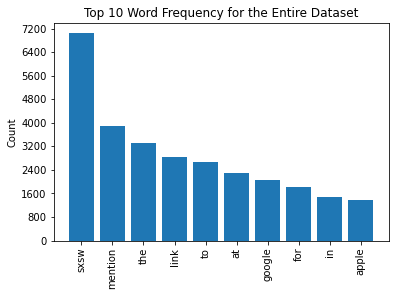

In [72]:
sample_freq_dist = FreqDist(df['Tokens'].explode())
visualize_top_10(sample_freq_dist,
                 'Top 10 Word Frequency for the Entire Dataset')

Now I'll display the word frequencies for each of the targets.

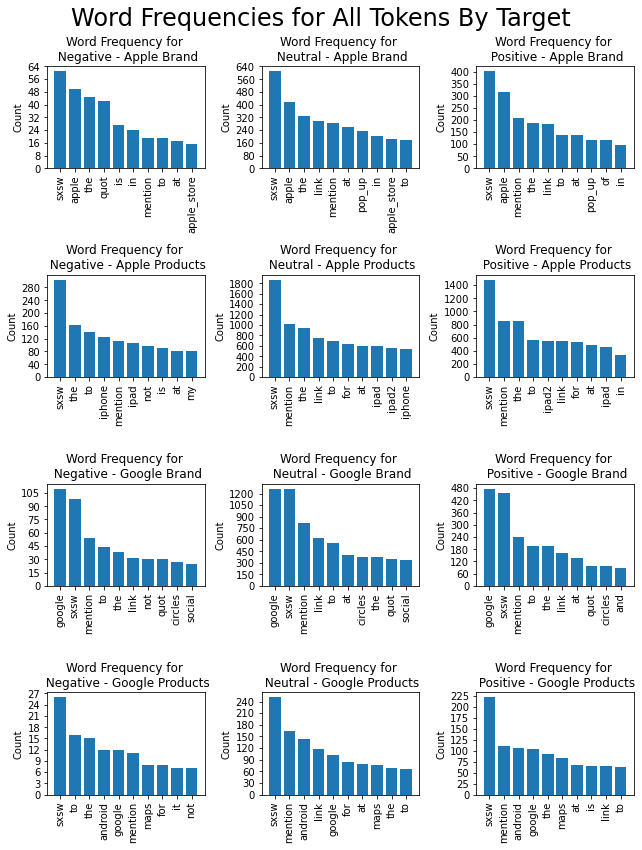

In [73]:
fig, axes = setup_twelve_subplots()
plots(df, df['Target'], "Tokens", axes)
fig.suptitle("Word Frequencies for All Tokens By Target", fontsize=24);

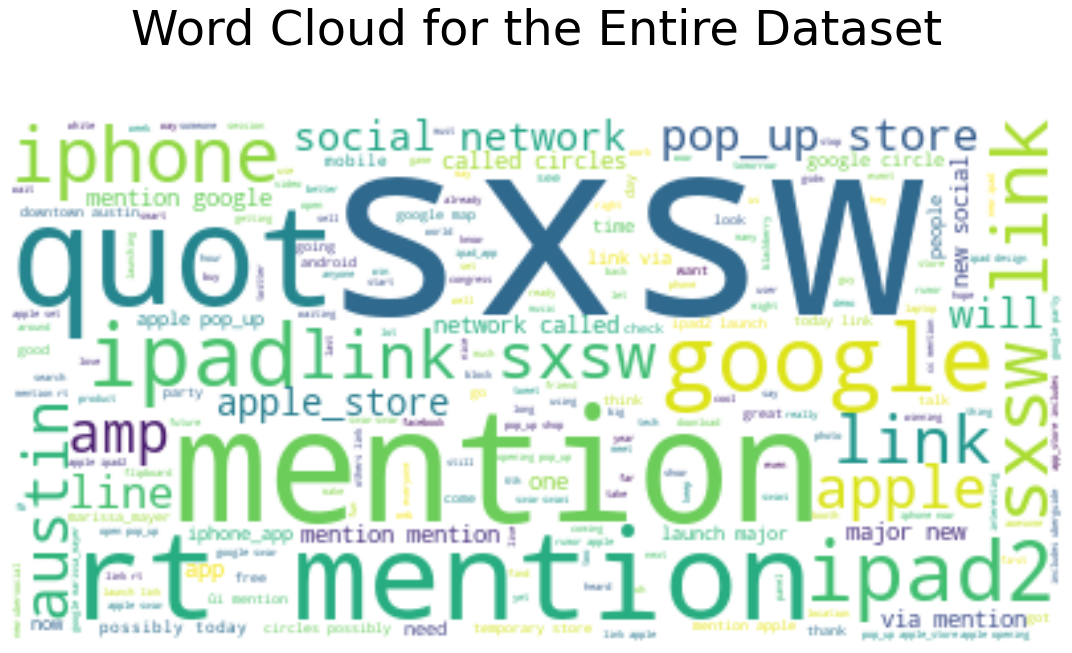

In [74]:
wc(df['Tokens'], title="Word Cloud for the Entire Dataset")

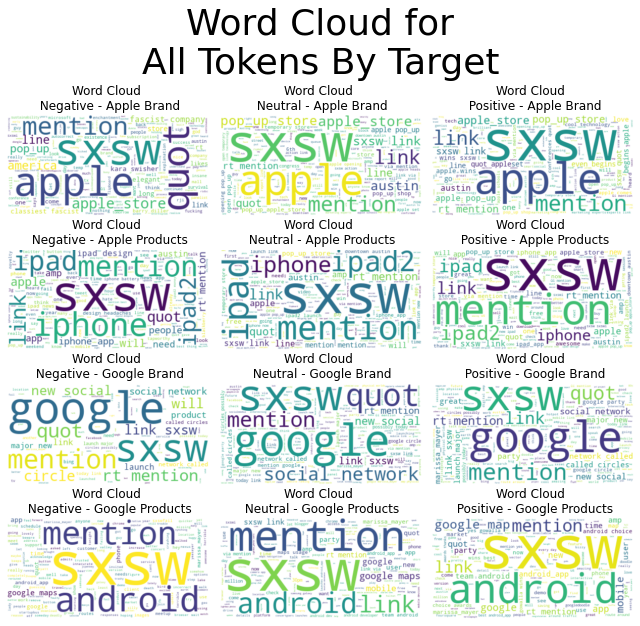

In [75]:
word_cloud_grid(df, df['Target'], 'Tokens',
                title="Word Cloud for\nAll Tokens By Target")

## Removing Stopwords

In [76]:
#Downloading the standard stopword list
nltk.download('stopwords', quiet=True)

stopwords_list = stopwords.words('english')

In [77]:
#Additional stopwords
stopwords_list.extend(['sxsw', '#sxsw', 'mention', 'rt', 'quot', 'link', 'amp',
                      'ûó', 'ûò', 'ûï', 'û_', 'ã_', 'ûª', 'åç', 'åè', 'ä_',
                       'â_', 'dì'])

In [78]:
def trim_stopwords(dfone):
    dfone.insert(2, 'Tidy Tweet', '')
    dfone.insert(5, 'Tokens Without Stopwords', '')
    dfone["Tokens Without Stopwords"] = dfone[
        "Tokens"].map(lambda x : remove_stopwords(x,stopwords_list))
    for ind in dfone.index:
        dfone.loc[ind, 'Tidy Tweet'] = " ".join(i
                            for i in dfone.at[ind, 'Tokens Without Stopwords'])
    return dfone.copy()

df = trim_stopwords(df)

df['Tidy Tweet'].head()

0                                  wesley83 3g iphone hrs tweeting rise_austin dead need upgrade plugin stations
1                     jessedee know fludapp awesome ipad iphone_app likely appreciate design also giving free ts
2                                                                                swonderlin wait ipad2 also sale
3                                                                      hope year festival crashy year iphone_app
4    sxtxstate great stuff fri marissa_mayer google tim_o_reilly tech books conferences matt_mullenweg wordpress
Name: Tidy Tweet, dtype: object

Now I'll display the word frequencies for the dataset with the removed stopwords.

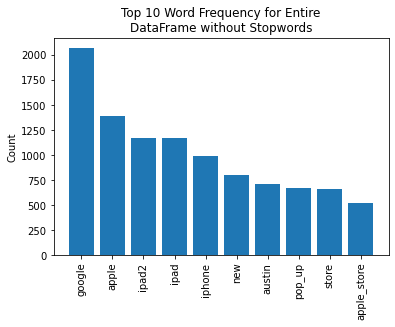

In [79]:
sample_freq_dist = FreqDist(df["Tokens Without Stopwords"].explode())
visualize_top_10(
    sample_freq_dist,
    'Top 10 Word Frequency for Entire\nDataFrame without Stopwords')

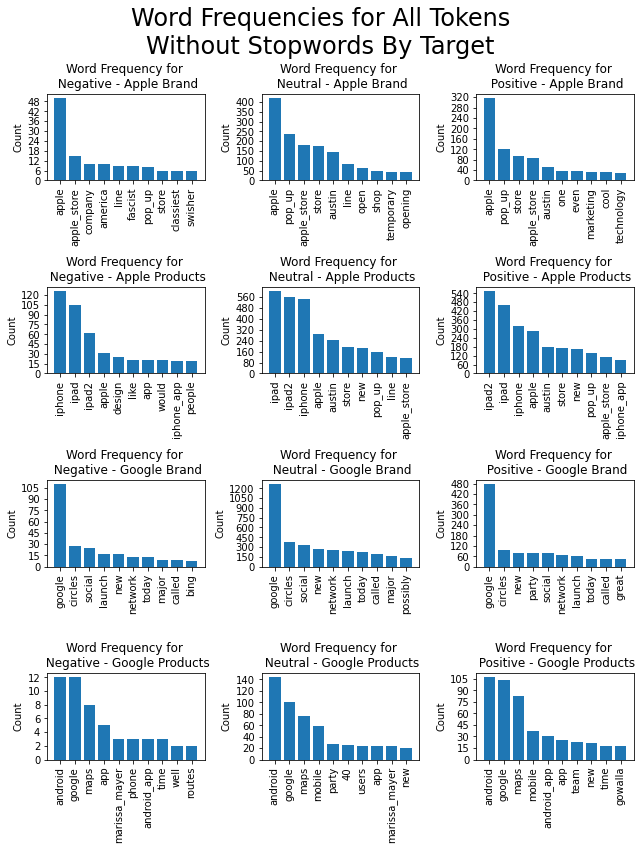

In [80]:
fig, axes = setup_twelve_subplots()
plots(df, df['Target'], "Tokens Without Stopwords", axes)
fig.suptitle("Word Frequencies for All Tokens\nWithout Stopwords By Target",
             fontsize=24);

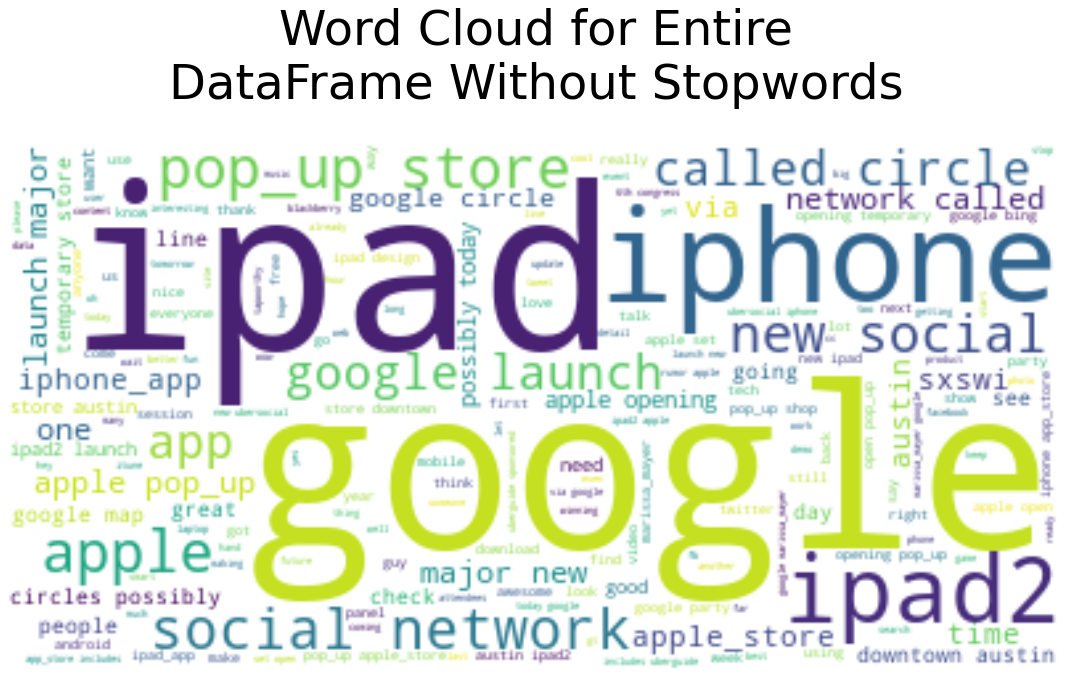

In [81]:
wc(df['Tokens Without Stopwords'],
   title="Word Cloud for Entire\nDataFrame Without Stopwords")

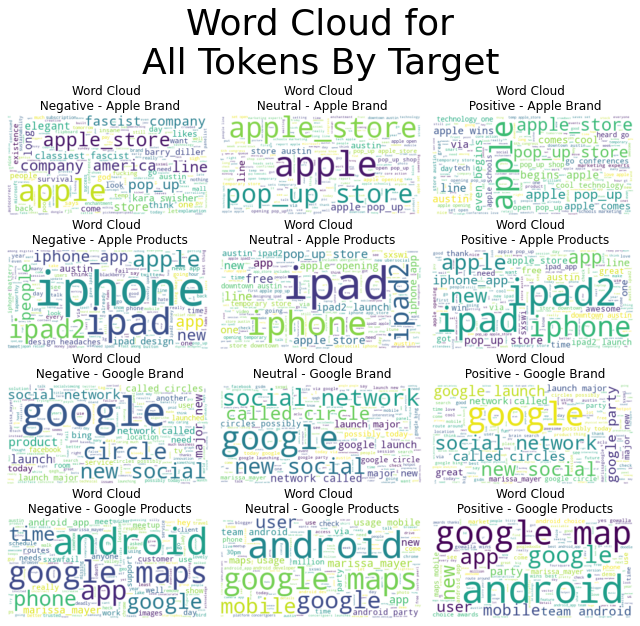

In [82]:
word_cloud_grid(df, df['Target'], 'Tokens Without Stopwords',
                title="Word Cloud for\nAll Tokens By Target")

## Stemmer Tokens

I want to see how the accuracy changes if I stem it with the snowball Stemmer. I won't make a separate column for the stemmed tweets though. I instead, I'll just use the stem_and_tokenize function below to test accuracy differences when using this method.

In [83]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer(language="english")

def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]

In [84]:
# The stopwords themselves needed to be stemmed.
stemmed_stopwords = [stemmer.stem(word) for word in stopwords_list]

In [85]:
def stem_tokens(dfone):
    dfone.insert(3, 'Stemmed Tweet', '')
    dfone.insert(7, 'Stemmed Tokens', '')
    dfone["Stemmed Tokens"] = dfone[
        "Tokens"].map(lambda x : remove_stopwords(x,stemmed_stopwords))
    for ind in dfone.index:
        dfone.loc[ind, 'Stemmed Tweet'] = " ".join(i
                            for i in dfone.at[ind, 'Stemmed Tokens'])
    return dfone.copy()

df = stem_tokens(df)

df.loc[0:4,['Stemmed Tweet', 'Stemmed Tokens']]

Stemmed Tweet  \
0                                wesley83 3g iphone hrs tweeting rise_austin dead need upgrade plugin stations   
1               jessedee know fludapp awesome ipad iphone_app likely appreciate its design also giving free ts   
2                                                                              swonderlin wait ipad2 also sale   
3                                                                    hope year festival crashy year iphone_app   
4  sxtxstate great stuff fri marissa_mayer google tim_o_reilly tech books conferences matt_mullenweg wordpress   

                                                                                                             Stemmed Tokens  
0                                 [wesley83, 3g, iphone, hrs, tweeting, rise_austin, dead, need, upgrade, plugin, stations]  
1             [jessedee, know, fludapp, awesome, ipad, iphone_app, likely, appreciate, its, design, also, giving, free, ts]  
2                                                                                     [swonderlin, wait, ipad2, also, sale]  
3                                                                          [hope, year, festival, crashy, year, iphone_app]  
4  [sxtxstate, great, stuff, fri, marissa_mayer, google, tim_o_reilly, tech, books, conferences, matt_mullenweg, wordpress]

In [86]:
df

Tweet  \
0                        .@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead!  i need to upgrade. plugin stations at #sxsw.   
1         @jessedee know about @fludapp ? awesome ipad/iphone_app that you will likely appreciate for its design. also, they are giving free ts at #sxsw   
2                                                                         @swonderlin can not wait for #ipad2 also. they should sale them down at #sxsw.   
3                                                                    @sxsw i hope this year's festival is not as crashy as this year's iphone_app. #sxsw   
4                    @sxtxstate great stuff on fri #sxsw: marissa_mayer (google), tim_o_reilly (tech books/conferences) &amp; matt_mullenweg (wordpress)   
...                                                                                                                                                  ...   
6614                                                                                                                       ipad everywhere. #sxsw {link}   
6615                       wave, buzz... rt @mention we interrupt your regularly scheduled #sxsw geek programming with big news {link}  #google #circles   
6616  google's zeiger, a physician never reported potential ae. yet fda relies on physicians. &quot;we are operating w/out data.&quot; #sxsw #health2dev   
6617        some verizon iphone customers complained their time fell back an hour this weekend.  of course they were the new yorkers who attended #sxsw.   
6618                                            œï¡žïàšü_‹ê‹î‹ò‹£‹á‹ââ‹_‹£‹‹â_‹ûârt @mention google tests ‰ûïcheck-in offers‰û at #sxsw {link}   

       Emotion  \
0     Negative   
1     Positive   
2     Positive   
3     Negative   
4     Positive   
...        ...   
6614  Positive   
6615   Neutral   
6616   Neutral   
6617   Neutral   
6618   Neutral   

                                                                                                       Tidy Tweet  \
0                                   wesley83 3g iphone hrs tweeting rise_austin dead need upgrade plugin stations   
1                      jessedee know fludapp awesome ipad iphone_app likely appreciate design also giving free ts   
2                                                                                 swonderlin wait ipad2 also sale   
3                                                                       hope year festival crashy year iphone_app   
4     sxtxstate great stuff fri marissa_mayer google tim_o_reilly tech books conferences matt_mullenweg wordpress   
...                                                                                                           ...   
6614                                                                                              ipad everywhere   
6615                             wave buzz interrupt regularly scheduled geek programming big news google circles   
6616      google zeiger physician never reported potential ae yet fda relies physicians operating data health2dev   
6617                  verizon iphone customers complained time fell back hour weekend course new yorkers attended   
6618                                                                œï žïàšü_ ââ ûârt google tests ûïcheck offers   

                                                                                                    Stemmed Tweet  \
0                                   wesley83 3g iphone hrs tweeting rise_austin dead need upgrade plugin stations   
1                  jessedee know fludapp awesome ipad iphone_app likely appreciate its design also giving free ts   
2                                                                                 swonderlin wait ipad2 also sale   
3                                                                       hope year festival crashy year iphone_app   
4     sxtxstate great stuff fri marissa_mayer google tim_o_reilly t

### Splitting the data into Train and Test sets
I will use the 80/20 split for Train vs Test sets of data. I will split each target listed above by this same ratio.

In [87]:
#Creating the Test/Train split
xtrain, xtest, ytrain, ytest = train_test_split(df.iloc[:, 0:-1],
                                                    df.iloc[:, -1],
                                                    train_size=.8,
                                                    random_state=42)

In [88]:
#I'm paranoid that the function will somehow pick few of one of the less common
#targets and then won't recognize it in the test. So I will test to see how
#close the ratio between train/test split is to the specified 0.8 train size
#for each target.

for targ in range(len(ytrain.unique())):
    train_size = ytrain.value_counts()[targ]
    test_size = ytest.value_counts()[targ]
    train_perc = round(train_size / (train_size + test_size), 3)
    print(targ, '-', train_perc)

0 - 0.717
1 - 0.752
2 - 0.778
3 - 0.815
4 - 0.812
5 - 0.795
6 - 0.786
7 - 0.813
8 - 0.795
9 - 0.792
10 - 0.852
11 - 0.785


I'm impressed. This is nigh perfect. I'll trust this function more in the future.

# Building Vectorization Techniques
For this NLP analysis, I will test three vectorization methods against five different models. 

Vectorization Techniques:
1. TF-IDF
2. Bag-Of-Words
3. Word2Vec

The models:
1. Multinomial Naive Bayes
2. Logistic Regression
3. Support Vector Machine
4. RandomForest
5. XGBoost

## Build TF-IDF Vectorizer and Evaluate it with a Baseline Model, Multinomial Naive Bayes

Now, I'm going to construct the first vectorizer, TfidVectorizer, and test different options using the model MultinomialNB and K-fold Cross Validation. The goal in this section is to find the best options for the TfidVectorizer. I will vectorize the corpus with four different options:
1. No special options.
2. Removing Stopwords
3. Removing Stems
4. Tweaking maximum features

### Basic TF-IDF vectorizer

In [89]:
# Import the TfidfVectorizer class
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate a vectorizer with max_features=10
# Default token pattern
tfidf = TfidfVectorizer(max_features=10)

# Fit the vectorizer on xtrain["text"] and transform it
xtrain_tfidf = tfidf.fit_transform(xtrain['Tweet'])

pd.set_option('display.precision', 5)

In [90]:
#Testing to see if the data is in the correct format
assert xtrain_tfidf.shape[0] == xtrain.shape[0]
assert xtrain_tfidf.shape[1] == 10

In [91]:
# I need to get the relevant sklearn functions
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()

# Evaluate the classifier on xtrain_tfidf and ytrain
baseline_cv = cross_val_score(baseline_model, xtrain_tfidf, ytrain)
baseline_cv

array([0.44381492, 0.44664778, 0.45042493, 0.44570349, 0.44664778])

In [92]:
ytrain.value_counts(normalize=True)

4    0.266
5    0.210
7    0.185
1    0.078
8    0.067
2    0.053
3    0.045
10   0.038
11   0.032
6    0.015
0    0.008
9    0.004
Name: Target, dtype: float64

Using K-fold Cross Validation Scores five times with the Multinomial Naive Bayes classifier yields accurate classifier predictions of around 40%. This is better than randomly guessing each value as the class 4 Neutral Apple Product classifier. There's room for improvement.

### TF-IDF vectorizer with Stopwords Removed

In [93]:
# Now, I want to test to see if the vectorized data shows an improvement when
# ran through the baseline model and K-fold cross validation.
tfidf = TfidfVectorizer(max_features=10, stop_words=stopwords_list)

# Fit the vectorizer on xtrain["text"] and transform it
xtrain_tfidf = tfidf.fit_transform(xtrain["Tweet"])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(xtrain_tfidf,
                                  columns=tfidf.get_feature_names_out()).head()

apple  apple_store  austin  google  ipad  ipad2  iphone   new  pop_up  \
0  0.000        0.000   0.000   1.000 0.000  0.000   0.000 0.000   0.000   
1  0.000        0.000   0.000   0.000 0.000  1.000   0.000 0.000   0.000   
2  0.000        0.000   0.000   0.000 0.000  0.000   0.000 0.000   0.000   
3  0.000        0.000   0.000   0.000 0.687  0.000   0.727 0.000   0.000   
4  0.000        0.000   0.000   1.000 0.000  0.000   0.000 0.000   0.000   

   store  
0  0.000  
1  0.000  
2  0.000  
3  0.000  
4  0.000

In [94]:
# Evaluate the classifier on xtrain_tfidf and ytrain
stopwords_removed_cv = cross_val_score(baseline_model, xtrain_tfidf,
                                       ytrain)
stopwords_removed_cv

array([0.5184136 , 0.50613787, 0.51935788, 0.52502361, 0.51558074])

In [95]:
# Now I'll see how the two models compare.
print("Baseline:         ", baseline_cv.mean())
print("Stopwords removed:", stopwords_removed_cv.mean())

Baseline:          0.44664778092540136
Stopwords removed: 0.5169027384324835


Removing a standard list of stop words actually caused a slight increase in the model's accuracy. Let's see what happens when I get rid of my own set of stopwords.

### TF-IDF vectorizer with Stemmed Stopwords Removed

In [96]:
tfidf = TfidfVectorizer(max_features=10,
                        stop_words=stemmed_stopwords,
                        tokenizer=stem_and_tokenize,
                        token_pattern=None)

# Fit the vectorizer on xtrain["text"] and transform it
xtrain_tfidf = tfidf.fit_transform(xtrain["Tweet"])

In [97]:
stemmed_cv = cross_val_score(baseline_model, xtrain_tfidf, ytrain)
stemmed_cv

array([0.49480642, 0.496695  , 0.50613787, 0.50236072, 0.50141643])

In [98]:
print("Baseline:         ", baseline_cv.mean())
print("Stopwords removed:", stopwords_removed_cv.mean())
print("Stemmed:          ", stemmed_cv.mean())

Baseline:          0.44664778092540136
Stopwords removed: 0.5169027384324835
Stemmed:           0.5002832861189802


A better improvement, but still nothing substantial. Now I'll try increasing the max features to the maximum number of tokens.

### TF-IDF Vectorizer with tweaked Max Features

I like to test things to see what yields the highest possible value. Below, I test which maximum features is best for Multinomial Naives Bayes.

In [99]:
tfidf = TfidfVectorizer(
    max_features=77,
    stop_words=stopwords_list,
)

# Fit the vectorizer on xtrain["text"] and transform it
xtrain_tfidf = tfidf.fit_transform(xtrain["Tweet"])
xtest_tfidf = tfidf.fit_transform(xtest["Tweet"])

In [100]:
max_features = cross_val_score(baseline_model, xtrain_tfidf, ytrain)
max_features

array([0.57507082, 0.58356941, 0.58734655, 0.57034939, 0.54863078])

In [101]:
print("Baseline:         ", baseline_cv.mean())
print("Stopwords removed:", stopwords_removed_cv.mean())
print("Stemmed:          ", stemmed_cv.mean())
print("Max Features:     ", max_features.mean())
mnb_tfidf_xtrain_kfold = max_features

Baseline:          0.44664778092540136
Stopwords removed: 0.5169027384324835
Stemmed:           0.5002832861189802
Max Features:      0.5729933899905572


Stemming the tweets did not help the K-fold score much at all. I'll stick with just removing stopwords, rather than stemming. I'll use the same stopword list in the the following two word vectorizors.

## Build Bag-Of-Words Vectorizer

In [102]:
from sklearn.feature_extraction.text import CountVectorizer

In [103]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2,
                                 max_features=10000,
                                 stop_words = stopwords_list)
df_bow = bow_vectorizer.fit_transform(df['Tidy Tweet'])
xtrain_bow = df_bow[ytrain.index]
xtest_bow  = df_bow[ytest.index]
print(xtrain_bow.shape, xtest_bow.shape)

(5295, 4187) (1324, 4187)


In [104]:
mnb_bow_xtrain_kfold = cross_val_score(baseline_model, xtrain_bow, ytrain)
mnb_bow_xtrain_kfold

array([0.55807365, 0.58734655, 0.61189802, 0.5694051 , 0.59395656])

In [105]:
print("TF-IDF:           ", mnb_tfidf_xtrain_kfold.mean())
print('Bag Of Words:     ', mnb_bow_xtrain_kfold.mean())

TF-IDF:            0.5729933899905572
Bag Of Words:      0.5841359773371104


## Build Word2Vec Vectorizer

In [106]:
import gensim

vsize = 782
def word2vec_model(tokens):
    model = gensim.models.Word2Vec(
        tokens, #Panda series of lists with word tokens in it.
        vector_size = vsize,  # desired no. of features/independent variables
        window=5,  # context window size
        min_count=1,  # Ignores all words with total frequency lower than 2.
        sg=1,  # 1 for skip-gram model
        hs=0,
        negative=10,  # for negative sampling
        workers=32,  # no.of cores
        seed=34)
    model.train(tokens, total_examples=len(tokens), epochs=20)
    return model

model_w2v_df = word2vec_model(df['Tokens Without Stopwords'])

In [107]:
def word_vector(model, tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model.wv[word].reshape(1, size)
            count += 1
        except KeyError:  # handling the case where the token is not in
            continue      # vocabulary
    if count != 0:
        vec /= count
    return vec

In [108]:
def word2Vec(tokens, vector_size):
    wordvec_arrays = np.zeros((len(tokens), vector_size))
    array_index = 0
    for i in tokens.index:
        wordvec_arrays[array_index, :] = word_vector(model_w2v_df,
                                                     tokens[i], vector_size)
        array_index += 1
    wordvec_df = pd.DataFrame(wordvec_arrays)
    print('Word2Vec Shape:', wordvec_df.shape)
    
    #PredictorScaler=StandardScaler()
    PredictorScaler = MinMaxScaler()

    # Storing the fit object for later reference
    PredictorScalerFit = PredictorScaler.fit(wordvec_df)

    # Generating the standardized values of X
    wordvec_norm = PredictorScalerFit.transform(wordvec_df)
    
    return wordvec_df, wordvec_norm

In [109]:
print('X-Train Word2Vec:')
xtrain_w2v, xtrain_w2v_norm = word2Vec(xtrain['Tokens Without Stopwords'],
                                        vsize)

print('X-Test Word2Vec:')
xtest_w2v, xtest_w2v_norm = word2Vec(xtest['Tokens Without Stopwords'],
                                        vsize)

X-Train Word2Vec:
Word2Vec Shape: (5295, 782)
X-Test Word2Vec:
Word2Vec Shape: (1324, 782)


In [110]:
mnb_w2v_xtrain_kfold = cross_val_score(baseline_model,
                                        xtrain_w2v_norm, ytrain)
mnb_w2v_xtrain_kfold

array([0.43909348, 0.43248347, 0.45420208, 0.45892351, 0.44475921])

In [111]:
print("TF-IDF:           ", mnb_tfidf_xtrain_kfold.mean())
print('Bag Of Words:     ', mnb_bow_xtrain_kfold.mean())
print('Word2Vec:         ', mnb_w2v_xtrain_kfold.mean())

TF-IDF:            0.5729933899905572
Bag Of Words:      0.5841359773371104
Word2Vec:          0.4458923512747875


## Doc2Vec

from tqdm import tqdm 
tqdm.pandas(desc="progress-bar") 
from gensim.models.doc2vec import TaggedDocument

def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(TaggedDocument(s, ["tweet_" + str(i)]))
    return output

labeled_tweets = add_label(xtrain['Tokens Without Stopwords']) # label all the tweets

model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model
                                  dm_mean=1, 
                        # dm_mean = 1 for using mean of the context word vectors
                                  vector_size=200, # no. of desired features
                                  window=5, # width of the context window
                                  negative=7, 
                                  # if > 0 then negative sampling will be used
                                  min_count=5, 
                        # Ignores all words with total frequency lower than 5.
                                  workers=32, # no. of cores
                                  alpha=0.1, # learning rate
                                  seed = 23, # for reproducibility
                                 ) 

model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

xtrain.at[418,'Tidy Tweet']

model_d2v.train(xtrain.at[418,'Tokens Without Stopwords'], total_examples= len(
    xtrain.at[418,'Tidy Tweet']), epochs=1)

The example gave the above epochs 15, not 1.

docvec_arrays = np.zeros((len(xtrain['Tokens Without Stopwords']), 200)) 
for i in xtrain.index:
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,200))    

docvec_df = pd.DataFrame(docvec_arrays) 
docvec_df.shape

# Positive and Negative Word Associations

In [112]:
def retain(dforg):
    df_new = rename_columns(dforg)

    df_new['Tweet'] = df_new['Tweet'].str.lower()

    df_new.drop(index=6, inplace=True)
    df_new.reset_index(drop=True, inplace=True)

    df_new = string_replace(df_new, first_replace, replacements,
                            to_print = False)

    df_new = tokenize_columns(df_new)
    
    df_new = tokens_with_hashtags(df_new)
    
    df_new, no_keywords_new, keyapple, keygoogle, keyall = keyword_labels(
                                                                    df_new)    

    df_new = company_organization(df_new, keyapple, keygoogle)

    df_new = company_by_product(df_new)
    
    df_new = no_match(df_new)

    df_new = mismatch(df_new)
    
    inspect, no_keywords_new = no_keywords(df_new, no_keywords_new)
    
    apple_tweets_new = tweets_to_edit(no_keywords_new, inspect, False)
    
    df_new.insert(11, 'Apps', False)
    keyapple.append('Apps')
    
    df_new, no_keywords_new = apple_tweet_edit(df_new,
                                            no_keywords_new, apple_tweets_new)
    
    df_new, no_keywords_new = corrections(df_new, no_keywords_new)
    
    df_new = categorize(df_new, keyapple, keygoogle)
        
    df_new = keyword_combos(df_new, keyapple, keygoogle)
 
    df_new = df_new.loc[:, ['Tweet', 'Emotion', 'Tokens', 'Hashtags',
                            'Keywords', 'Company', 'Category']].copy()

    df_new.reset_index(drop=True, inplace=True)
    
    df_new = abbreviate_emotion(df_new)
        
    df_new = emotion_columns(df_new)
    
    df_new = trim_stopwords(df_new)
    
    df_new = stem_tokens(df_new)
    
    model_w2v_df_new = word2vec_model(df_new['Tokens Without Stopwords'])
    
    return df_new, model_w2v_df_new

df_retain, model_w2v_df_retain = retain(df_raw)

In [113]:
df_retain[['Tidy Tweet', 'Tokens Without Stopwords', 'Hashtags',
           'Keywords', 'Target Text', 'Target']].head()

Tidy Tweet  \
0                                wesley83 3g iphone hrs tweeting rise_austin dead need upgrade plugin stations   
1                   jessedee know fludapp awesome ipad iphone_app likely appreciate design also giving free ts   
2                                                                              swonderlin wait ipad2 also sale   
3                                                                    hope year festival crashy year iphone_app   
4  sxtxstate great stuff fri marissa_mayer google tim_o_reilly tech books conferences matt_mullenweg wordpress   

                                                                                                   Tokens Without Stopwords  \
0                                 [wesley83, 3g, iphone, hrs, tweeting, rise_austin, dead, need, upgrade, plugin, stations]   
1                  [jessedee, know, fludapp, awesome, ipad, iphone_app, likely, appreciate, design, also, giving, free, ts]   
2                                                                                     [swonderlin, wait, ipad2, also, sale]   
3                                                                          [hope, year, festival, crashy, year, iphone_app]   
4  [sxtxstate, great, stuff, fri, marissa_mayer, google, tim_o_reilly, tech, books, conferences, matt_mullenweg, wordpress]   

                Hashtags              Keywords                Target Text  \
0  [#rise_austin, #sxsw]                iPhone  Negative - Apple Products   
1                [#sxsw]       iPad iPhone_App  Positive - Apple Products   
2        [#ipad2, #sxsw]                 iPad2  Positive - Apple Products   
3                [#sxsw]            iPhone_App  Negative - Apple Products   
4                [#sxsw]  Google Marissa_Mayer    Positive - Google Brand   

   Target  
0       3  
1       5  
2       5  
3       3  
4       8

In [114]:
# I'm curious if I'll get dramatically different answers if I run the Word2Vec
# Vectorization process separtley on DataFrames created exclusively for each
# target. Only one way to find out.

titles = {}

df_w2v_neg_ab = df.loc[df['Target Text'] == 'Negative - Apple Brand']
model_w2v_neg_ab = word2vec_model(df_w2v_neg_ab['Tokens Without Stopwords'])
titles[model_w2v_neg_ab] = 'Negative - Apple Brand'

df_w2v_neu_ab = df.loc[df['Target Text'] == 'Neutral - Apple Brand']
model_w2v_neu_ab = word2vec_model(df_w2v_neu_ab['Tokens Without Stopwords'])
titles[model_w2v_neu_ab] = 'Neutral - Apple Brand'

df_w2v_pos_ab = df.loc[df['Target Text'] == 'Positive - Apple Brand']
model_w2v_pos_ab = word2vec_model(df_w2v_pos_ab['Tokens Without Stopwords'])
titles[model_w2v_pos_ab] = 'Positive - Apple Brand'

df_w2v_neg_ap = df.loc[df['Target Text'] == 'Negative - Apple Products']
model_w2v_neg_ap = word2vec_model(df_w2v_neg_ap['Tokens Without Stopwords'])
titles[model_w2v_neg_ap] = 'Negative - Apple Products'

df_w2v_neu_ap = df.loc[df['Target Text'] == 'Neutral - Apple Products']
model_w2v_neu_ap = word2vec_model(df_w2v_neu_ap['Tokens Without Stopwords'])
titles[model_w2v_neu_ap] = 'Neutral - Apple Products'

df_w2v_pos_ap = df.loc[df['Target Text'] == 'Positive - Apple Products']
model_w2v_pos_ap = word2vec_model(df_w2v_pos_ap['Tokens Without Stopwords'])
titles[model_w2v_pos_ap] = 'Positive - Apple Products'

df_w2v_neg_gb = df.loc[df['Target Text'] == 'Negative - Google Brand']
model_w2v_neg_gb = word2vec_model(df_w2v_neg_gb['Tokens Without Stopwords'])
titles[model_w2v_neg_gb] = 'Negative - Google Brand'

df_w2v_neu_gb = df.loc[df['Target Text'] == 'Neutral - Google Brand']
model_w2v_neu_gb = word2vec_model(df_w2v_neu_gb['Tokens Without Stopwords'])
titles[model_w2v_neu_gb] = 'Neutral - Google Brand'

df_w2v_pos_gb = df.loc[df['Target Text'] == 'Positive - Google Brand']
model_w2v_pos_gb = word2vec_model(df_w2v_pos_gb['Tokens Without Stopwords'])
titles[model_w2v_pos_gb] = 'Positive - Google Brand'

df_w2v_neg_gp = df.loc[df['Target Text'] == 'Negative - Google Products']
model_w2v_neg_gp = word2vec_model(df_w2v_neg_gp['Tokens Without Stopwords'])
titles[model_w2v_neg_gp] = 'Negative - Google Products'

df_w2v_neu_gp = df.loc[df['Target Text'] == 'Neutral - Google Products']
model_w2v_neu_gp = word2vec_model(df_w2v_neu_gp['Tokens Without Stopwords'])
titles[model_w2v_neu_gp] = 'Neutral - Google Products'

df_w2v_pos_gp = df.loc[df['Target Text'] == 'Positive - Google Products']
model_w2v_pos_gp = word2vec_model(df_w2v_pos_gp['Tokens Without Stopwords'])
titles[model_w2v_pos_gp] = 'Positive - Google Products'

df_w2v_neg_a = df.loc[(df['Company'] == 'Apple') & 
                      (df['Emotion'] == 'Negative')]
model_w2v_neg_a = word2vec_model(df_w2v_neg_a['Tokens Without Stopwords'])
titles[model_w2v_neg_a] = 'Negative - Apple (Products & Brand)'

df_w2v_neu_a = df.loc[(df['Company'] == 'Apple') & 
                      (df['Emotion'] == 'Neutral')]
model_w2v_neu_a = word2vec_model(df_w2v_neu_a['Tokens Without Stopwords'])
titles[model_w2v_neu_a] = 'Neutral - Apple (Products & Brand)'

df_w2v_pos_a = df.loc[(df['Company'] == 'Apple') & 
                      (df['Emotion'] == 'Positive')]
model_w2v_pos_a = word2vec_model(df_w2v_pos_a['Tokens Without Stopwords'])
titles[model_w2v_pos_a] = 'Positive - Apple (Products & Brand)'

df_w2v_neg_g = df.loc[(df['Company'] == 'Google') & 
                      (df['Emotion'] == 'Negative')]
model_w2v_neg_g = word2vec_model(df_w2v_neg_g['Tokens Without Stopwords'])
titles[model_w2v_neg_g] = 'Negative - Google (Products & Brand)'

df_w2v_neu_g = df.loc[(df['Company'] == 'Google') & 
                      (df['Emotion'] == 'Neutral')]
model_w2v_neu_g = word2vec_model(df_w2v_neu_g['Tokens Without Stopwords'])
titles[model_w2v_neu_g] = 'Neutral - Google (Products & Brand)'

df_w2v_pos_g = df.loc[(df['Company'] == 'Google') & 
                      (df['Emotion'] == 'Positive')]
model_w2v_pos_g = word2vec_model(df_w2v_pos_g['Tokens Without Stopwords'])
titles[model_w2v_pos_g] = 'Positive - Google (Products & Brand)'

In [115]:
apple_brand_wv =     [model_w2v_neg_ab,
                      model_w2v_neu_ab,
                      model_w2v_pos_ab]
apple_products_wv =  [model_w2v_neg_ap,
                      model_w2v_neu_ap,
                      model_w2v_pos_ap]
google_brand_wv =    [model_w2v_neg_gb,
                      model_w2v_neu_gb,
                      model_w2v_pos_gb]
google_products_wv = [model_w2v_neg_gp,
                      model_w2v_neu_gp,
                      model_w2v_pos_gp]
apple_both_wv =       [model_w2v_neg_a,
                      model_w2v_neu_a,
                      model_w2v_pos_a]
google_both_wv =      [model_w2v_neg_g,
                      model_w2v_neu_g,
                      model_w2v_pos_g]

apple_all_wv = []
apple_all_wv.extend(apple_brand_wv)
apple_all_wv.extend(apple_products_wv)
apple_all_wv.extend(apple_both_wv)

google_all_wv = []
google_all_wv.extend(google_brand_wv)
google_all_wv.extend(google_products_wv)
google_all_wv.extend(google_both_wv)
all_wv = []
all_wv.extend(apple_all_wv)
all_wv.extend(google_all_wv)

In [116]:
def word_association(mdl, wrd):
    if wrd not in mdl.wv.key_to_index:
        string = 'The word "' + wrd.capitalize() + '" is not in the model '
        string += titles[mdl]
        return  string, ''
    pos = mdl.wv.most_similar(positive=wrd)
    neg = mdl.wv.most_similar(negative=wrd)
    return pos, neg

def word_association_visual(model_lst, word):
    if type(model_lst) is not list:
        temp = []
        temp.append(model_lst)
        model_lst = temp
    for model in model_lst:
        pos_tup_lst, neg_tup_lst = word_association(model, word)
        if type(pos_tup_lst) is str:
            print(pos_tup_lst)
            continue
        
        first = 'Word Clouds for\n'
        mid = titles[model] + ' Tweets\n'
        last  =  'Associated With The Word "{}"'.format(word.capitalize())
        model_title = first + mid + last
        word_assoc_cloud(pos_tup_lst, neg_tup_lst, word, 
            title = model_title)
        
        max_len = 0
        for i in range(len(pos_tup_lst)):
            if len(pos_tup_lst[i][0]) > max_len:
                max_len = len(pos_tup_lst[i][0])
            if len(neg_tup_lst[i][0]) > max_len:
                max_len = len(neg_tup_lst[i][0])
        for i in range(len(pos_tup_lst)):
            pos_txt = pos_tup_lst[i][0]
            neg_txt = neg_tup_lst[i][0]
            spaces_pos = ''
            spaces_neg = ''
            between_space = ''
            pos_num = str('%.3f' % round(pos_tup_lst[i][1],3))
            neg_num = str('%.3f' % round(neg_tup_lst[i][1],3))
            num_spaces_pos = max_len - len(pos_txt) + 4
            num_spaces_neg = max_len - len(neg_txt) + 4
            if float(pos_num) < 0:
                num_spaces_pos -= 1
            if float(neg_num) < 0:
                num_spaces_neg -= 1
            for i in range(num_spaces_pos):
                spaces_pos += ' '
            for i in range(num_spaces_neg):
                spaces_neg += ' '
            txt =  '(' + pos_txt + spaces_pos + pos_num + ')'
            between = 40 - len(txt)
            for i in range(between):
                between_space += ' '
            txt += between_space + '(' + neg_txt + spaces_neg + neg_num + ')'
            print(txt)
        print()
    return 

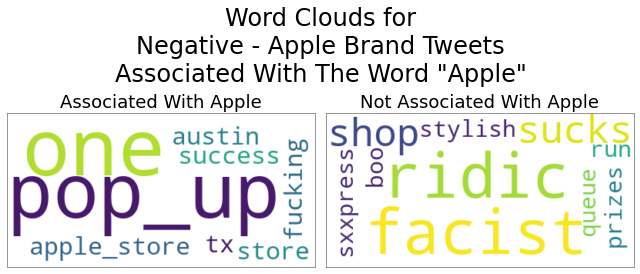

(one            1.000)                  (ridic         -0.999)
(pop_up         1.000)                  (facist        -0.999)
(apple_store    1.000)                  (sucks         -0.999)
(store          1.000)                  (shop          -0.999)
(like           1.000)                  (stylish       -0.999)
(austin         1.000)                  (queue         -0.999)
(success        1.000)                  (sxxpress      -0.999)
(tx             1.000)                  (run           -0.999)
(fucking        1.000)                  (prizes        -0.999)
(get            1.000)                  (boo           -0.999)



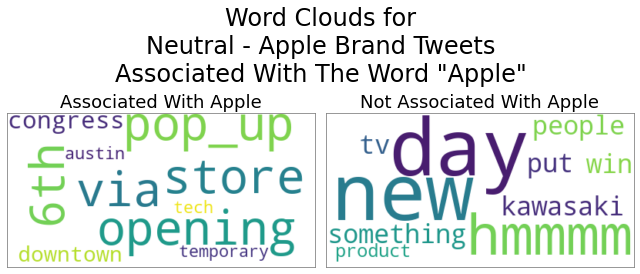

(via          0.995)                    (day         -0.798)
(opening      0.992)                    (new         -0.817)
(pop_up       0.991)                    (hmmmm       -0.826)
(store        0.989)                    (something   -0.827)
(6th          0.989)                    (win         -0.831)
(congress     0.988)                    (kawasaki    -0.837)
(downtown     0.988)                    (people      -0.842)
(temporary    0.986)                    (put         -0.847)
(tech         0.982)                    (tv          -0.847)
(austin       0.977)                    (product     -0.849)



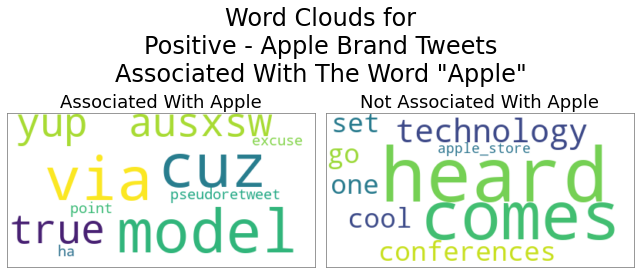

(via              0.999)                (heard           -0.818)
(cuz              0.994)                (ever            -0.819)
(model            0.993)                (comes           -0.824)
(ausxsw           0.993)                (technology      -0.826)
(true             0.993)                (conferences     -0.832)
(yup              0.993)                (cool            -0.834)
(pseudoretweet    0.992)                (go              -0.840)
(ha               0.992)                (one             -0.852)
(point            0.991)                (set             -0.880)
(excuse           0.990)                (apple_store     -0.890)



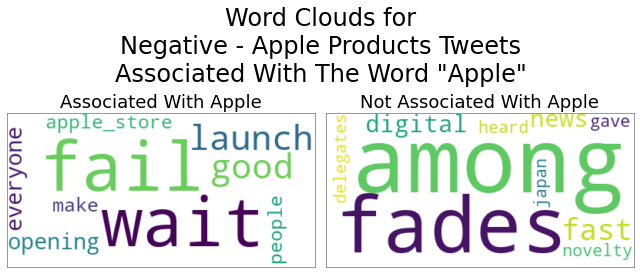

(would          0.998)                  (among         -0.631)
(fail           0.998)                  (fades         -0.641)
(wait           0.998)                  (fast          -0.644)
(launch         0.998)                  (digital       -0.664)
(good           0.998)                  (news          -0.684)
(opening        0.998)                  (novelty       -0.684)
(everyone       0.998)                  (delegates     -0.687)
(apple_store    0.998)                  (japan         -0.713)
(make           0.998)                  (gave          -0.714)
(people         0.998)                  (heard         -0.716)



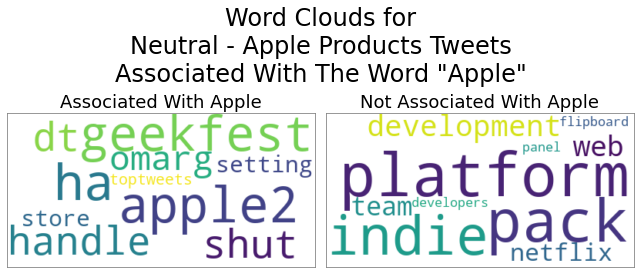

(ha             0.950)                  (platform      -0.073)
(apple2         0.948)                  (pack          -0.106)
(geekfest       0.947)                  (indie         -0.130)
(handle         0.945)                  (development   -0.132)
(dt             0.944)                  (web           -0.132)
(shut           0.944)                  (team          -0.134)
(omarg          0.942)                  (netflix       -0.139)
(setting        0.942)                  (flipboard     -0.139)
(store          0.941)                  (panel         -0.153)
(toptweets      0.941)                  (developers    -0.159)



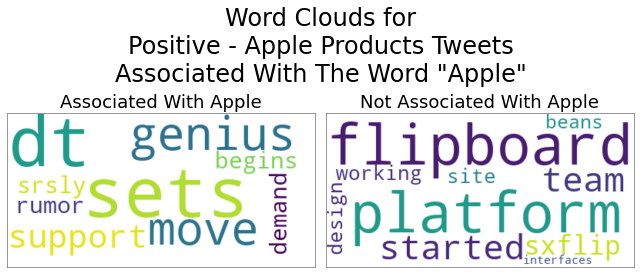

(sets          0.985)                   (platform     -0.113)
(dt            0.984)                   (flipboard    -0.136)
(000           0.983)                   (started      -0.141)
(genius        0.982)                   (team         -0.166)
(move          0.982)                   (sxflip       -0.169)
(support       0.981)                   (working      -0.184)
(begins        0.980)                   (design       -0.197)
(srsly         0.979)                   (site         -0.204)
(rumor         0.979)                   (beans        -0.212)
(demand        0.977)                   (interfaces   -0.213)



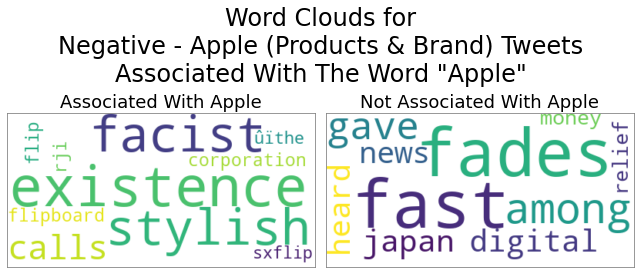

(existence      0.995)                  (fades         -0.586)
(stylish        0.991)                  (fast          -0.590)
(facist         0.991)                  (among         -0.591)
(calls          0.991)                  (gave          -0.600)
(corporation    0.991)                  (digital       -0.612)
(flipboard      0.991)                  (japan         -0.615)
(rji            0.991)                  (heard         -0.619)
(flip           0.991)                  (news          -0.623)
(sxflip         0.990)                  (money         -0.623)
(ûïthe          0.989)                  (relief        -0.625)



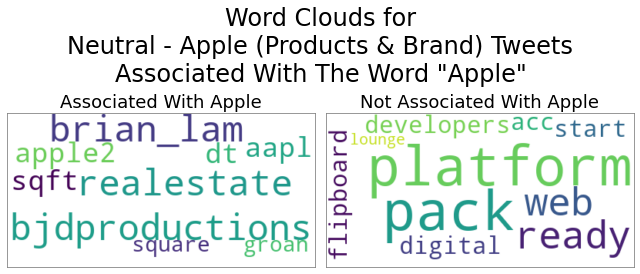

(bjdproductions    0.854)               (platform         -0.105)
(realestate        0.852)               (pack             -0.107)
(brian_lam         0.846)               (ready            -0.140)
(apple2            0.844)               (web              -0.148)
(000               0.844)               (developers       -0.152)
(aapl              0.843)               (flipboard        -0.171)
(sqft              0.842)               (digital          -0.175)
(dt                0.840)               (start            -0.181)
(groan             0.839)               (acc              -0.185)
(square            0.839)               (lounge           -0.189)



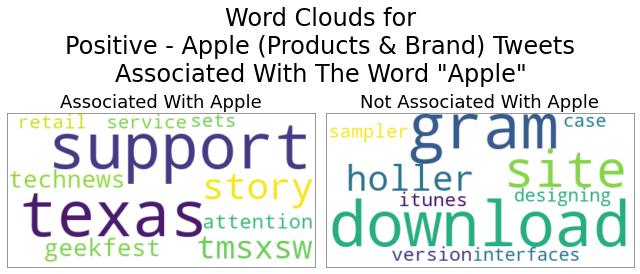

(texas         0.842)                   (download     -0.115)
(support       0.838)                   (gram         -0.122)
(story         0.838)                   (site         -0.124)
(tmsxsw        0.833)                   (holler       -0.134)
(geekfest      0.833)                   (sampler      -0.140)
(technews      0.830)                   (version      -0.141)
(attention     0.830)                   (itunes       -0.152)
(retail        0.829)                   (designing    -0.166)
(sets          0.827)                   (interfaces   -0.170)
(service       0.826)                   (case         -0.175)

The word "Apple" is not in the model Negative - Google Brand
The word "Apple" is not in the model Neutral - Google Brand
The word "Apple" is not in the model Positive - Google Brand
The word "Apple" is not in the model Negative - Google Products
The word "Apple" is not in the model Neutral - Google Products
The word "Apple" is not in the model Positive - Google Products
The wo

In [117]:
word_association_visual(all_wv, 'apple');

# Building Models
I will fit each vectorization technique with the following models:
1. Multinomial Naive Bayes 
2. Logistic Regression
3. Support Vector Machine
4. RandomForest
5. XGBoost

In [119]:
df[['Tidy Tweet', 'Tokens Without Stopwords', 'Hashtags',
           'Keywords', 'Target Text', 'Target']].head()

Tidy Tweet  \
0                                wesley83 3g iphone hrs tweeting rise_austin dead need upgrade plugin stations   
1                   jessedee know fludapp awesome ipad iphone_app likely appreciate design also giving free ts   
2                                                                              swonderlin wait ipad2 also sale   
3                                                                    hope year festival crashy year iphone_app   
4  sxtxstate great stuff fri marissa_mayer google tim_o_reilly tech books conferences matt_mullenweg wordpress   

                                                                                                   Tokens Without Stopwords  \
0                                 [wesley83, 3g, iphone, hrs, tweeting, rise_austin, dead, need, upgrade, plugin, stations]   
1                  [jessedee, know, fludapp, awesome, ipad, iphone_app, likely, appreciate, design, also, giving, free, ts]   
2                                                                                     [swonderlin, wait, ipad2, also, sale]   
3                                                                          [hope, year, festival, crashy, year, iphone_app]   
4  [sxtxstate, great, stuff, fri, marissa_mayer, google, tim_o_reilly, tech, books, conferences, matt_mullenweg, wordpress]   

                Hashtags              Keywords                Target Text  \
0  [#rise_austin, #sxsw]                iPhone  Negative - Apple Products   
1                [#sxsw]       iPad iPhone_App  Positive - Apple Products   
2        [#ipad2, #sxsw]                 iPad2  Positive - Apple Products   
3                [#sxsw]            iPhone_App  Negative - Apple Products   
4                [#sxsw]  Google Marissa_Mayer    Positive - Google Brand   

   Target  
0       3  
1       5  
2       5  
3       3  
4       8

## Multinomial Naive Bayes

In [120]:
f1_scores = pd.DataFrame(columns = ['Model', 'Vectorization', 
        'K-Fold', 'F1 Average Micro', 
        'F1 Average Macro', 'F1 Average Weighted'])

f1_scores

Empty DataFrame
Columns: [Model, Vectorization, K-Fold, F1 Average Micro, F1 Average Macro, F1 Average Weighted]
Index: []

In [121]:
baseline_model.fit(xtrain_tfidf, ytrain)

prediction = baseline_model.predict(xtest_tfidf)

avg = ['micro', 'macro', 'weighted']

df_row = ['Multinomial Naive Bayes', 'TF-IDF', mnb_tfidf_xtrain_kfold.mean()]
for a in range(len(avg)):
    df_row.append(f1_score(ytest, prediction, average = avg[a]))

f1_scores.loc[len(f1_scores)] = df_row

In [122]:
baseline_model.fit(xtrain_bow, ytrain)
prediction = baseline_model.predict(xtest_bow)

df_row = ['Multinomial Naive Bayes',
          'Bag-Of-Words', mnb_bow_xtrain_kfold.mean()]
for a in range(len(avg)):
    df_row.append(f1_score(ytest, prediction, average = avg[a]))

f1_scores.loc[len(f1_scores)] = df_row

In [123]:
baseline_model.fit(xtrain_w2v_norm, ytrain)
prediction = baseline_model.predict(xtest_w2v_norm)

df_row = ['Multinomial Naive Bayes', 'Word2Vec', mnb_w2v_xtrain_kfold.mean()]
for a in range(len(avg)):
    df_row.append(f1_score(ytest, prediction, average = avg[a]))

f1_scores.loc[len(f1_scores)] = df_row

In [124]:
f1_scores

Model Vectorization  K-Fold  F1 Average Micro  \
0  Multinomial Naive Bayes        TF-IDF   0.573             0.270   
1  Multinomial Naive Bayes  Bag-Of-Words   0.584             0.581   
2  Multinomial Naive Bayes      Word2Vec   0.446             0.451   

   F1 Average Macro  F1 Average Weighted  
0             0.149                0.236  
1             0.434                0.564  
2             0.331                0.436

## Logistic Regression

In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
lreg = LogisticRegression(solver='lbfgs', max_iter=8000)

In [126]:
log_tfidf_train = cross_val_score(lreg, xtrain_tfidf, ytrain)
log_tfidf_train.mean()

0.6020774315391879

In [127]:
log_bow_xtrain_kfold = cross_val_score(lreg, xtrain_bow, ytrain)
log_bow_xtrain_kfold.mean()

0.6355051935788479

In [128]:
log_w2v_xtrain_kfold = cross_val_score(lreg, xtrain_w2v_norm, ytrain)
log_w2v_xtrain_kfold.mean()

KeyboardInterrupt: 

In [ ]:
lreg.fit(xtrain_tfidf, ytrain)
prediction = lreg.predict(xtest_tfidf)

df_row = ['Logistic Regression', 'TF-IDF', log_tfidf_train.mean()]
for a in range(len(avg)):
    df_row.append(f1_score(ytest, prediction, average = avg[a]))

f1_scores.loc[len(f1_scores)] = df_row

In [ ]:
lreg.fit(xtrain_bow, ytrain)
prediction = lreg.predict(xtest_bow)

df_row = ['Logistic Regression', 'Bag-Of-Words', log_bow_xtrain_kfold.mean()]
for a in range(len(avg)):
    df_row.append(f1_score(ytest, prediction, average = avg[a]))

f1_scores.loc[len(f1_scores)] = df_row

In [ ]:
lreg.fit(xtrain_w2v, ytrain) 
prediction = lreg.predict(xtest_w2v)

df_row = ['Logistic Regression', 'Word2Vec', log_w2v_xtrain_kfold.mean()]
for a in range(len(avg)):
    df_row.append(f1_score(ytest, prediction, average = avg[a]))

f1_scores.loc[len(f1_scores)] = df_row

In [ ]:
f1_scores

## Support Vector Machine

In [ ]:
from sklearn import svm
svc = svm.SVC(kernel='linear', C=1, probability=True)

In [ ]:
svc_tfidf_xtrain_kfold = cross_val_score(svc, xtrain_tfidf, ytrain)
svc_tfidf_xtrain_kfold.mean()

In [ ]:
svc_bow_xtrain_kfold = cross_val_score(svc, xtrain_bow, ytrain)
svc_bow_xtrain_kfold.mean()

In [ ]:
svc_w2v_xtrain_kfold = cross_val_score(svc, xtrain_w2v, ytrain)
svc_w2v_xtrain_kfold.mean()

In [ ]:
svc.fit(xtrain_tfidf, ytrain)
prediction = svc.predict(xtest_tfidf)

avg = ['micro', 'macro', 'weighted']

df_row = ['Support Vector Machine', 'TF-IDF', svc_tfidf_xtrain_kfold.mean()]
for a in range(len(avg)):
    df_row.append(f1_score(ytest, prediction, average = avg[a]))

f1_scores.loc[len(f1_scores)] = df_row

In [ ]:
svc.fit(xtrain_bow, ytrain)
prediction = svc.predict(xtest_bow)

df_row = ['Support Vector Machine', 'Bag-Of-Words', svc_bow_xtrain_kfold.mean()]
for a in range(len(avg)):
    df_row.append(f1_score(ytest, prediction, average = avg[a]))

f1_scores.loc[len(f1_scores)] = df_row

In [ ]:
svc.fit(xtrain_w2v, ytrain)
prediction = svc.predict(xtest_w2v)

df_row = ['Support Vector Machine', 'Word2Vec', svc_w2v_xtrain_kfold.mean()]
for a in range(len(avg)):
    df_row.append(f1_score(ytest, prediction, average = avg[a]))

f1_scores.loc[len(f1_scores)] = df_row

In [ ]:
f1_scores

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=400, random_state=11)

In [ ]:
rf_tfidf_xtrain_kfold = cross_val_score(rf, xtrain_tfidf, ytrain)
rf_tfidf_xtrain_kfold.mean()

In [ ]:
rf_bow_xtrain_kfold = cross_val_score(rf, xtrain_bow, ytrain)
rf_bow_xtrain_kfold.mean()

In [ ]:
rf_w2v_xtrain_kfold = cross_val_score(rf, xtrain_w2v, ytrain)
rf_w2v_xtrain_kfold.mean()

In [ ]:
rf.fit(xtrain_tfidf, ytrain)
prediction = rf.predict(xtest_tfidf)

df_row = ['Random Forest', 'TF-IDF', rf_tfidf_xtrain_kfold.mean()]
for a in range(len(avg)):
    df_row.append(f1_score(ytest, prediction, average = avg[a]))

f1_scores.loc[len(f1_scores)] = df_row

In [ ]:
rf.fit(xtrain_bow, ytrain)
prediction = rf.predict(xtest_bow)

df_row = ['Random Forest', 'Bag-Of-Words', rf_bow_xtrain_kfold.mean()]
for a in range(len(avg)):
    df_row.append(f1_score(ytest, prediction, average = avg[a]))

f1_scores.loc[len(f1_scores)] = df_row

In [ ]:
rf.fit(xtrain_w2v, ytrain)
prediction = rf.predict(xtest_w2v)

df_row = ['Random Forest', 'Word2Vec', rf_w2v_xtrain_kfold.mean()]
for a in range(len(avg)):
    df_row.append(f1_score(ytest, prediction, average = avg[a]))

f1_scores.loc[11] = df_row

In [ ]:
f1_scores

## XGBoost

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=6, n_estimators=1000, num_class = 12,
                    use_label_encoder=False, eval_metric = 'mlogloss')

In [ ]:
xgb_tfidf_xtrain_kfold = cross_val_score(xgb, xtrain_tfidf, ytrain)
xgb_tfidf_xtrain_kfold.mean()

In [ ]:
xgb_bow_xtrain_kfold = cross_val_score(xgb, xtrain_bow, ytrain)
xgb_bow_xtrain_kfold.mean()

In [ ]:
xgb_w2v_xtrain_kfold = cross_val_score(xgb, xtrain_w2v, ytrain)
xgb_w2v_xtrain_kfold.mean()

In [ ]:
xgb.fit(xtrain_tfidf, ytrain)
prediction = xgb.predict(xtest_tfidf)

df_row = ['XGBoost', 'TF-IDF', xgb_tfidf_xtrain_kfold.mean()]
for a in range(len(avg)):
    df_row.append(f1_score(ytest, prediction, average = avg[a]))

f1_scores.loc[len(f1_scores)] = df_row

In [ ]:
xgb.fit(xtrain_bow, ytrain)
prediction = xgb.predict(xtest_bow)

df_row = ['XGBoost', 'Bag-Of-Words', xgb_bow_xtrain_kfold.mean()]
for a in range(len(avg)):
    df_row.append(f1_score(ytest, prediction, average = avg[a]))

f1_scores.loc[len(f1_scores)] = df_row

In [ ]:
xgb.fit(xtrain_w2v, ytrain)
prediction = xgb.predict(xtest_w2v)

df_row = ['XGBoost', 'Word2Vec', xgb_w2v_xtrain_kfold.mean()]
for a in range(len(avg)):
    df_row.append(f1_score(ytest, prediction, average = avg[a]))

f1_scores.loc[14] = df_row

In [ ]:
f1_scores

In [ ]:
print(f1_scores['F1 Average Micro'].max())
print(f1_scores['F1 Average Macro'].max())
print(f1_scores['F1 Average Weighted'].max())


# Questions for Morgan:
1. What should my Train Test split percentages be?
Typically 9000 stick to 20/25 for test.

What are the words that arise out of the positive or negative tweets that arise often? What services do people write about positively and negatively?

Write about how to use this model for the benefit. An actionable recommendation.


2. My steps are:
    1. Define the 5800 tweets as either Apple, Google, or delete them.
    2. Split data into Apple & Google Tweets. This will involve a word search seeing what key words are included in the tweet (Products and company names)
    3. Put it all in lower case.
    3a. Remove HTML, URLs, clean up mentions by deleting all @ symbols.
    4. Tokenize everything / evaluate frequencies
    5. Build a baseline model with TfidfVectorizer and MultinomialNB
    5a. Account Vectorizor
    6. The final NLP lab lists the next five considerations. I'm honestly a little puzzled by them at first glance as I did this a few months ago.
    * Do we remove stop words or not?
    * What should be counted as a token? Do we stem or lemmatize our text data, or leave the words as is? Do we want to include non-"words" in our tokens?
    * Do we engineer other features, such as bigrams, or POS tags, or Mutual Information Scores?
    * Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?
    * What sort of vectorization should we use in our model? Boolean Vectorization? Count Vectorization? TF-IDF? More advanced vectorization strategies such as Word2Vec?
    
Target is part of the model.
The projects will require us to have a target for 

# Meeting notes 2/27/23
Use Spell check (installed)
Use Prettyfy (installed)
Add visualizations earlier in the notebook
Use a confusion matrix for... something
Use Vectorizer to find associated words with positive and negative tokens associated with Google. This will help Google's analysis of the data on how to improve.
Increase the list of stopwords rather than rely on the given stopwords.

Also, Morgan didn't have a problem with any of the cuts I described, though I need to ask him two questions:

1. There were four sentiments: Negative, Neutral, Positive, and "I can't tell." I cut any tweet that had "I can't tell" assigned to it. That OK?

2. Do the target numbers have to be in sequential order, or can they be any number? Do they have to be 0, 1, 2..., or can I give them a number that represents the categorization of the tweet much like the first number of a hotel room indicates what floor you're on?

What I've got, the first digit represents company, the second the brand or the product, and the third the sentiment. So 221 represents Google Brand Negative.

# Questions for 3/3/23 meeting
I have read through The TfidVectorization section of the NLP cumulative lab twice and I still don't understand it. I'm going to move forward because the next sections do make sense, but I need to ask Morgan about this section.



EDA - Exploratory data analysis

Try other types model
TF/IDF (Random Forest, Support vector, logistic regression model)
Word2vec

TF-IDF - a way to encode texts to numerical values.
Bag of Words, and Word Embeddings - Other vectorization techniques with models?
Bag of Words is generally the crudest and least effective NLP technique.
Vectorization - encodes texts to numerical values.
Word2Vec = Word Embeddings

Cross_val_score is a good scoring system.

Best performing model in predicting sentiment.


Recommendations for marketing purposes. To help Google understand based on twitter data.
Vectorized similar words most common terms.
Model Word2Vec

Start reaching out stronger, outside the curriculum.

Look at the notebooks that Morgan shared is Slack.
Word2Vec is a model itself, based no other terms in the corpus.

Read up on all or this.
Clean up 
Use more modeling technicques (Do the confusion matrix)
Word2Vec
More Visualizations
Remember the Recomendations are a reflection of the problem statement.


## Observing the First Kaggle File Morgan sent me

### Make a funnel Chart of just positive, negative and neutral sentiment.

In [ ]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

### Make a number of words histogram plot:


In [ ]:
hist_data = [train['Num_words_ST'],train['Num_word_text']]

group_labels = ['Selected_Text', 'Text']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

### Make prettier word count list

In [ ]:
train['temp_list'] = train['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

### Another word histogram

In [ ]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

### Tree histogram

In [ ]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

### Donut histogram

In [ ]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Positive['count'], labels=Unique_Positive.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Positive Words')
plt.show()

From this first Kaggle, I learned that I can split the model into two models. One that figures out what Company/product it should concern, and one for sentiment. This might substantially improve the model.

In [ ]:
'''
fig, axes = setup_twelve_subplots()
plots(xtrain, ytrain, "Tokens Without Stopwords", axes)
fig.suptitle("Word Frequencies for X-Train\nWithout Stopwords by Target",
             fontsize=24);
'''

In [ ]:
'''
word_cloud_grid(xtrain, ytrain, 'Tokens Without Stopwords',
        title = "Word Cloud for X-Train\nWithout Stopwords By Target")
'''

In [ ]:
max_k_fold = 0
max_feat = 0
for i in range(10, 100):
    tfidf = TfidfVectorizer(
        max_features=i,
        stop_words=stopwords_list,
    )

    # Fit the vectorizer on xtrain["text"] and transform it
    xtrain_tfidf = tfidf.fit_transform(xtrain["Tweet"])

    max_features = cross_val_score(baseline_model, xtrain_tfidf, ytrain)
    if max_features.mean() > max_k_fold:
        max_k_fold = max_features.mean()
        max_feat = i
        print(max_feat, max_k_fold)

print('Complete')